In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import gc
from tqdm import tqdm
from collections import defaultdict

In [2]:
train = pd.read_pickle('data/train_original.pkl')
test = pd.read_pickle('data/test_original.pkl')
special_cols = [col for col in train.columns if train[col].dtype != np.float64]
feature_cols = [col for col in train.columns if col not in special_cols]

In [3]:
def transform_freq_feature(df1,df2,df3_base,feat):
    val1=df1[feat].values
    val2=df3_base[feat].values
    
    defa1=defaultdict(lambda:0)
    
    for val in val1:
        defa1[str(val)]+=1.
    for val in val2:
        defa1[str(val)]+=1.  
        
    df1[feat +"_freq"]= df1[feat].apply(lambda x :defa1[str(x)] ) 
    df2[feat+"_freq"]= df2[feat].apply(lambda x :defa1[str(x)] )  
    
def load_data():
    train_df = train[feature_cols].copy()
    test_df = test[feature_cols].copy()
    real_test_df = test[feature_cols].copy()

    unique_samples = []
    unique_count = np.zeros_like(test_df)
    for feature in tqdm(range(test_df.shape[1])):
        _, index_, count_ = np.unique(test_df.values[:, feature], return_counts=True, return_index=True)
        unique_count[index_[count_ == 1], feature] += 1
    
    # Samples which have unique values are real the others are fake
    real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
    synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]
    
    real_test_df=real_test_df.iloc[real_samples_indexes]
    print(real_test_df.shape[0])
    print(len(synthetic_samples_indexes))
    
    columns=train_df.columns.values
    for col in tqdm(columns):
        transform_freq_feature(train_df,test_df,real_test_df,col)
    '''
    train_df = pd.concat([train_df,
                          pd.read_pickle('features/cnt_diff_to_expected_norm_dist_train')], axis=1)
    test_df = pd.concat([test_df,
                        pd.read_pickle('features/cnt_diff_to_expected_norm_dist_test')], axis=1)
    
    for col in tqdm(columns[[6,110, 26, 146, 139, 21, 76, 174, 133, 99, 198, 109, 80, 13, 190, 148, 0, 44, 164]]):
        transform_gmm_feature(train_df,test_df,real_test_df,col)
    ''' 
    return train_df.fillna(-999), test_df.fillna(-999), real_samples_indexes

In [4]:
train_df, test_df, real_samples_indexes = load_data()

100%|████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 30.63it/s]


100000
100000


100%|████████████████████████████████████████████████████████████████████████████| 200/200 [02:24<00:00,  1.09s/it]


In [5]:
freq_cols = [f+'_freq' for f in feature_cols]

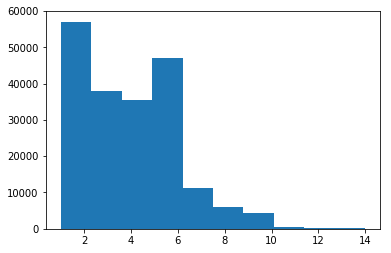

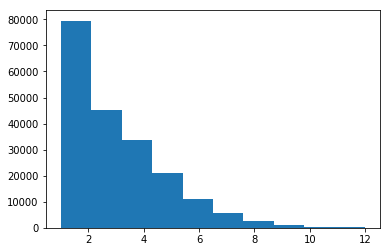

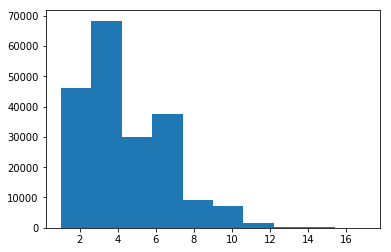

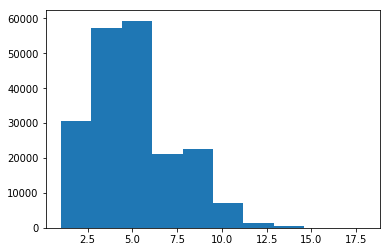

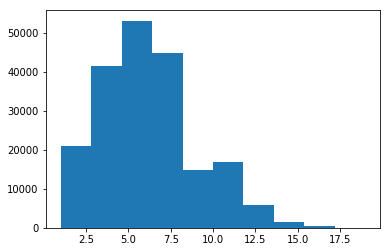

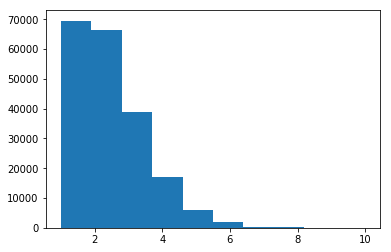

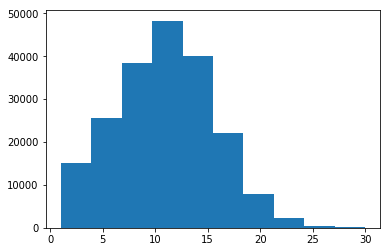

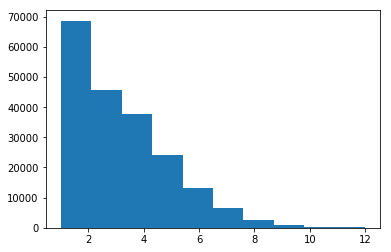

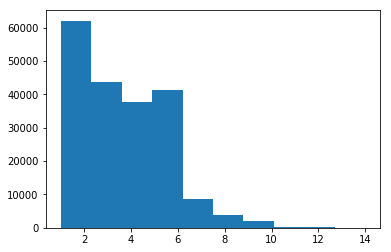

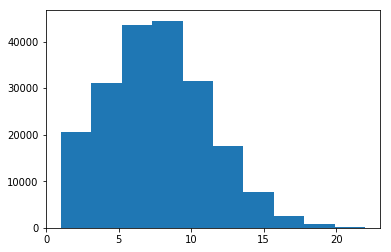

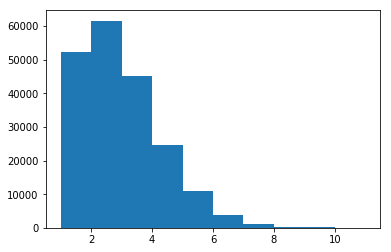

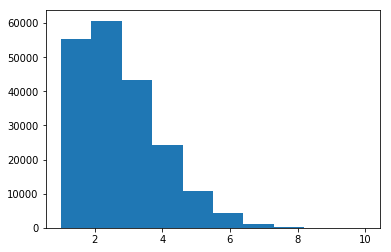

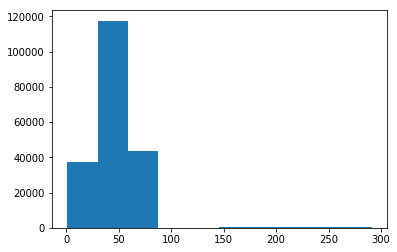

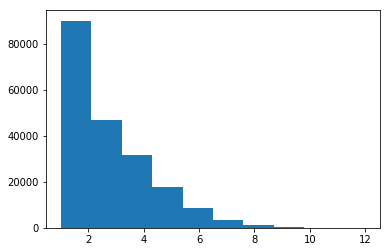

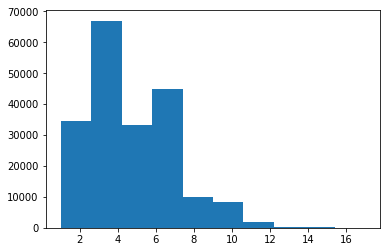

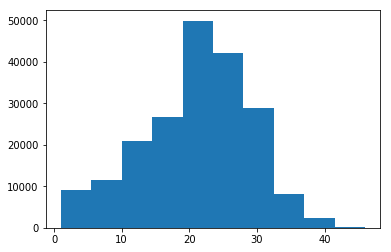

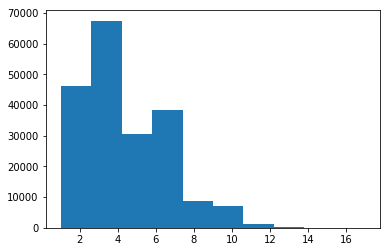

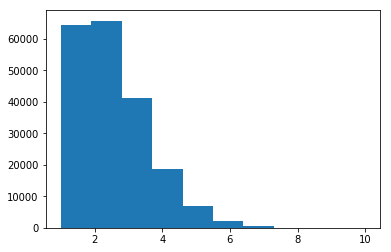

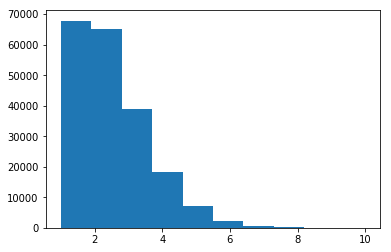

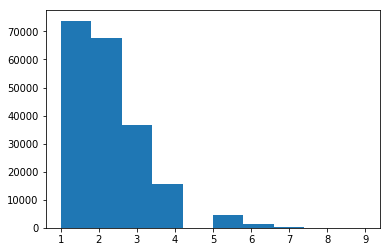

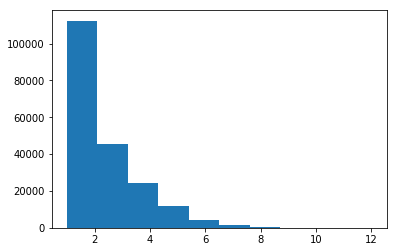

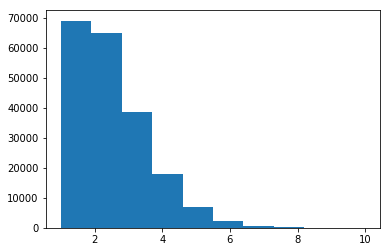

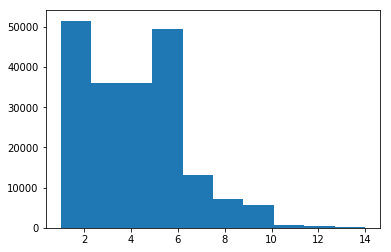

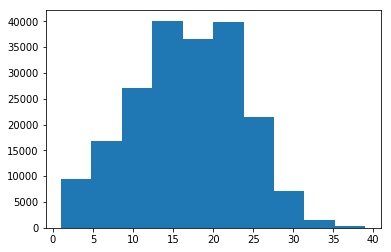

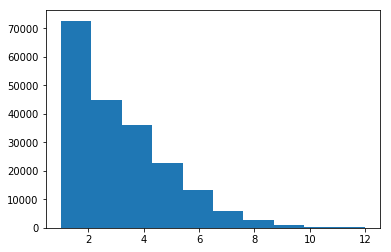

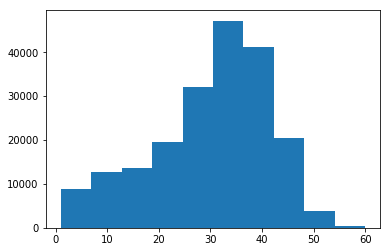

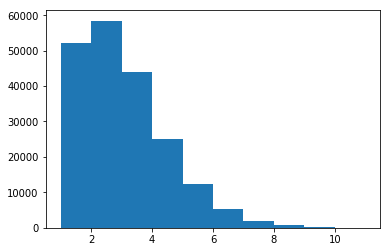

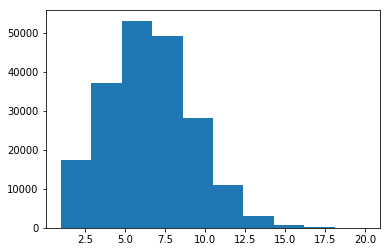

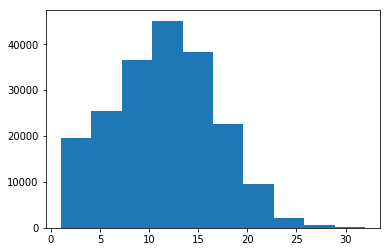

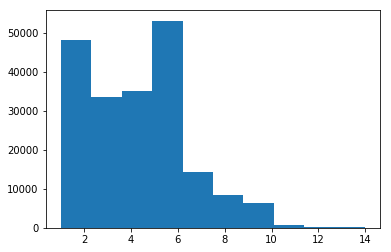

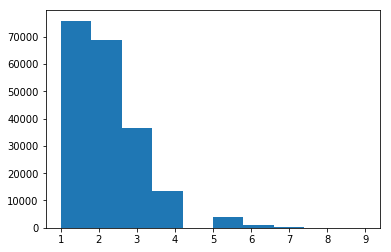

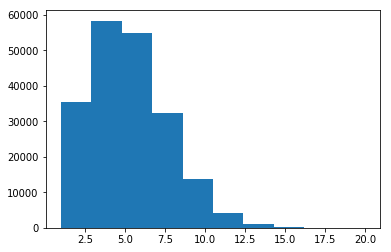

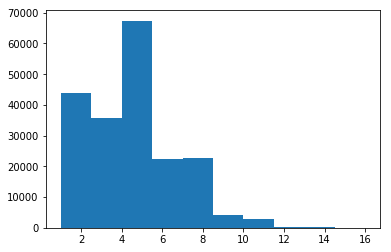

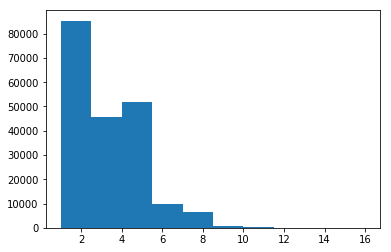

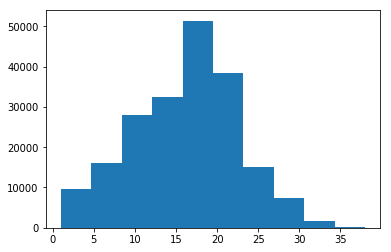

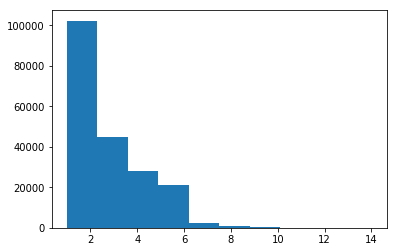

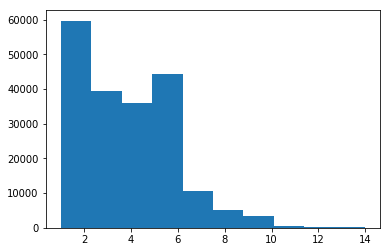

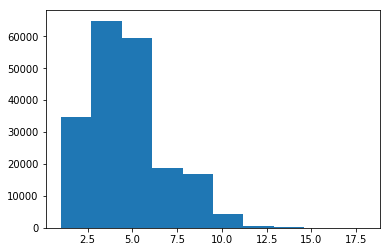

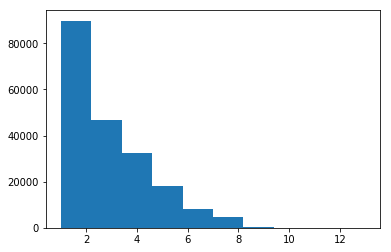

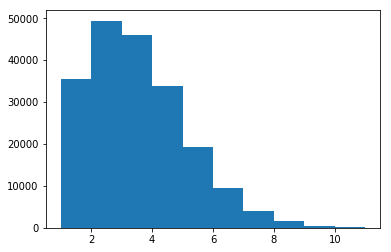

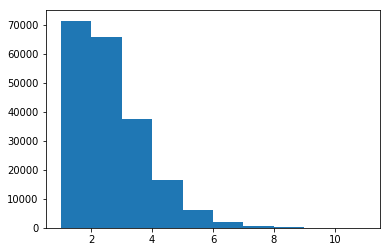

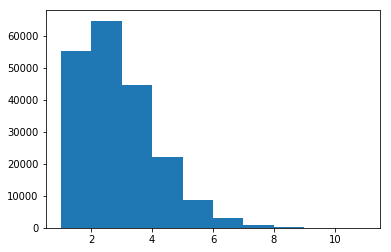

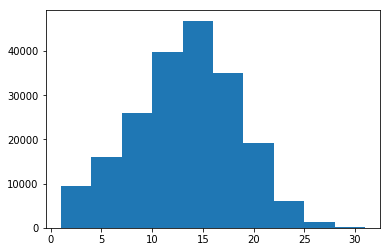

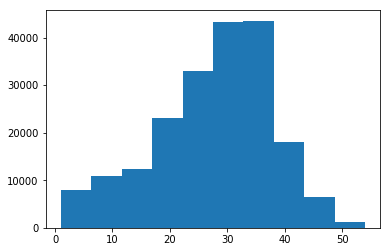

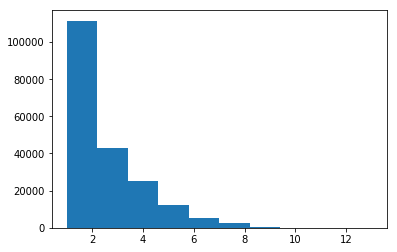

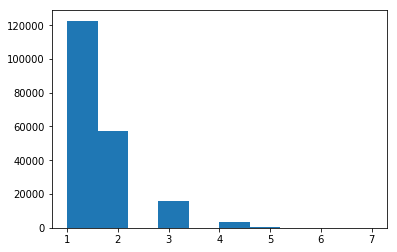

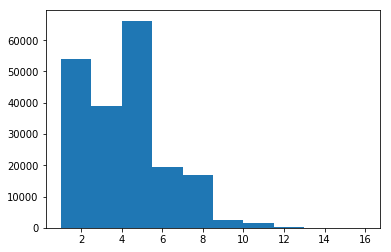

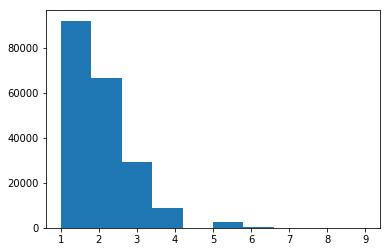

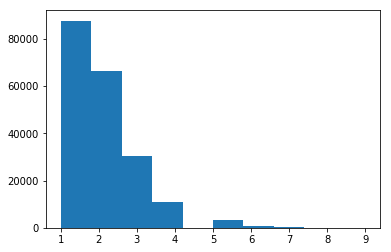

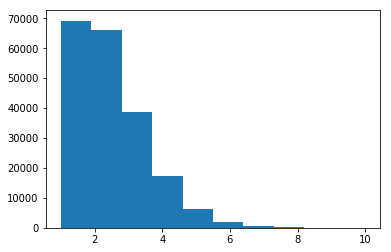

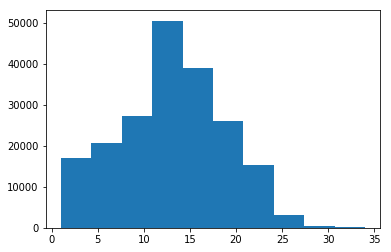

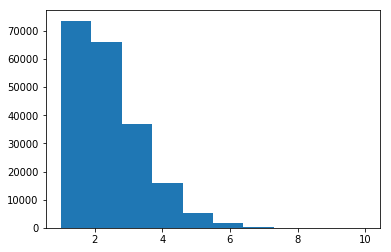

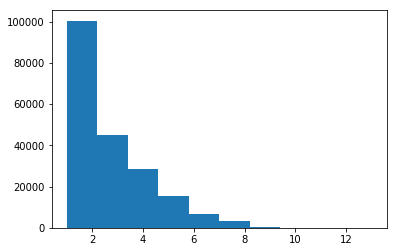

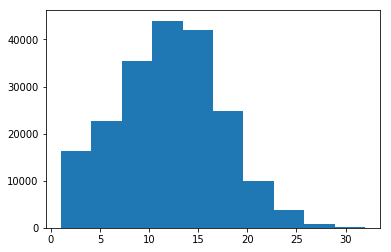

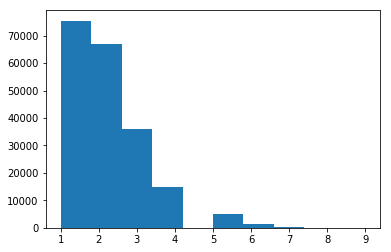

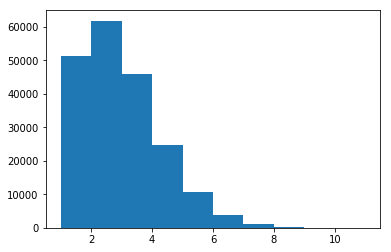

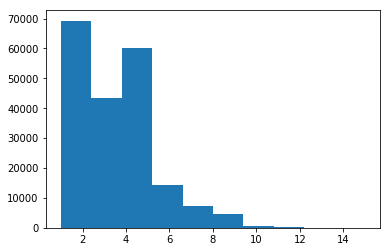

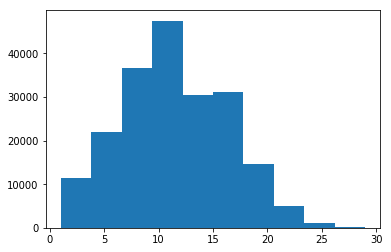

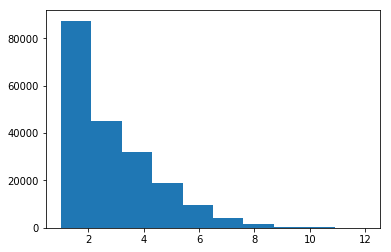

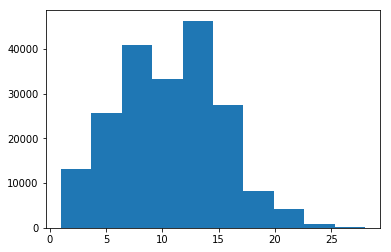

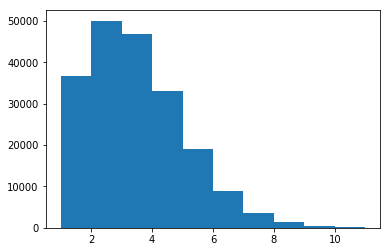

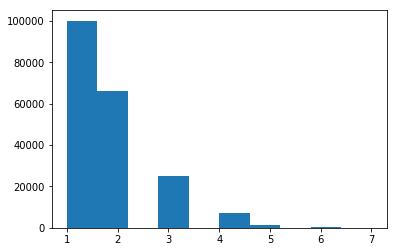

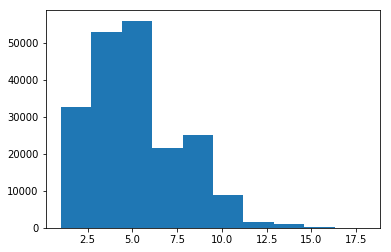

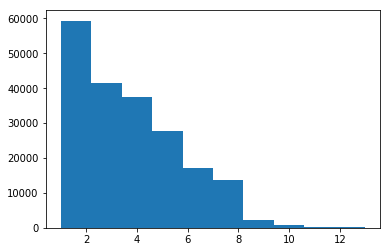

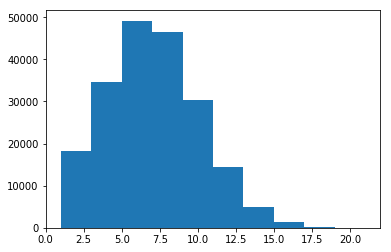

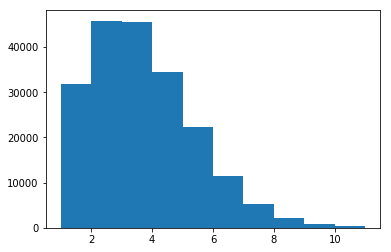

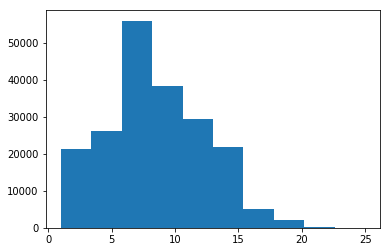

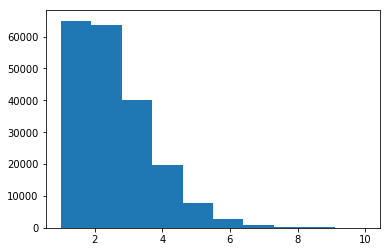

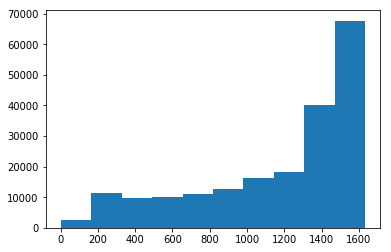

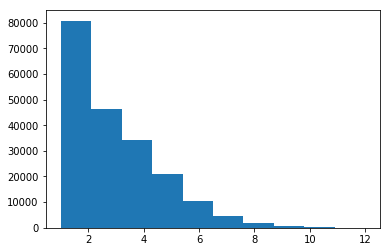

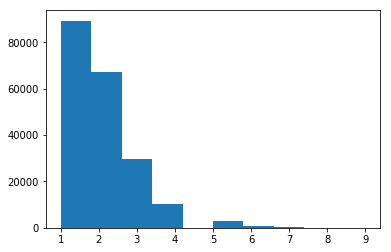

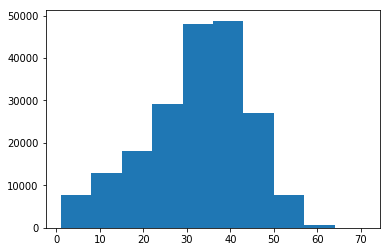

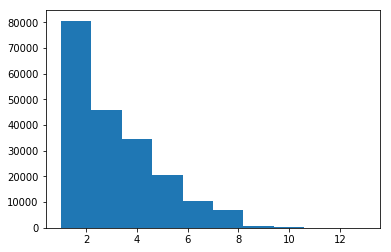

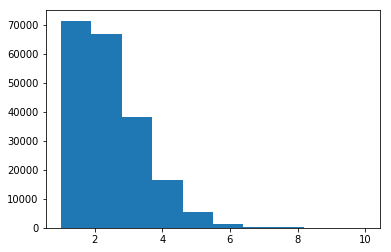

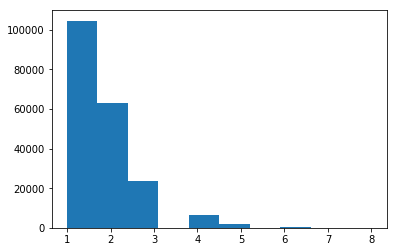

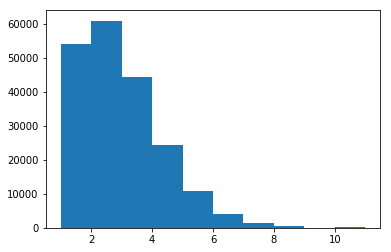

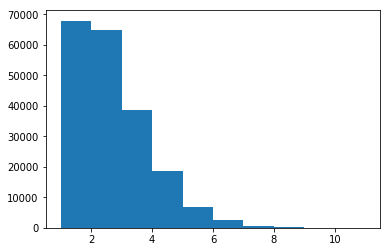

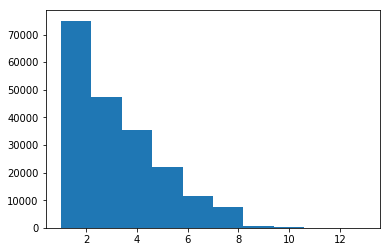

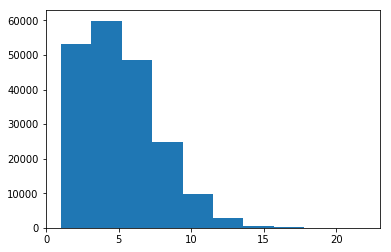

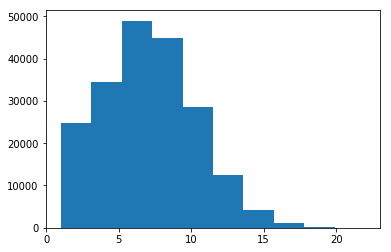

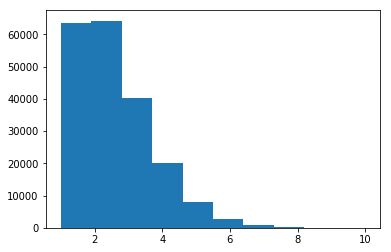

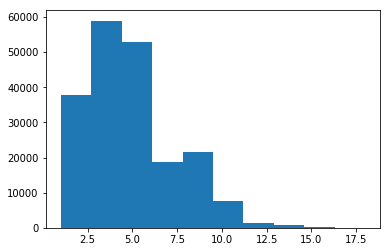

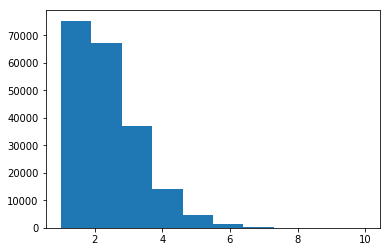

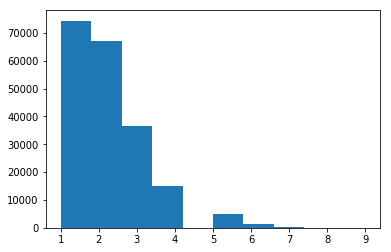

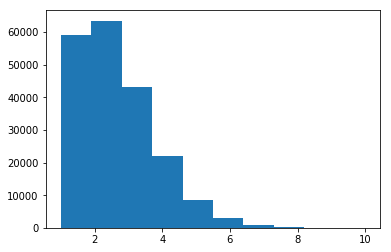

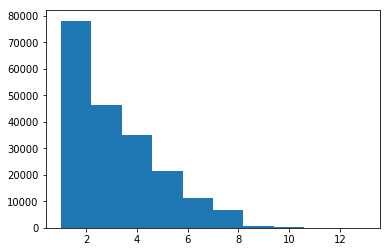

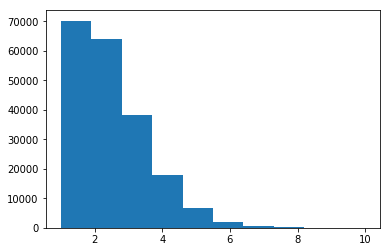

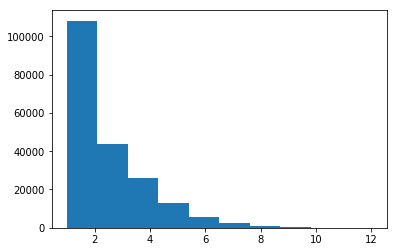

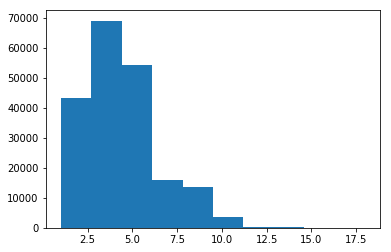

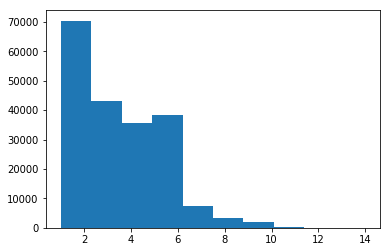

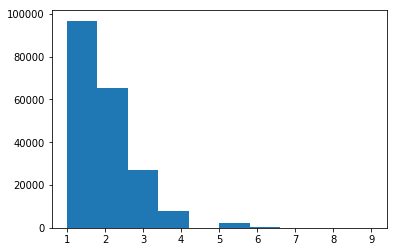

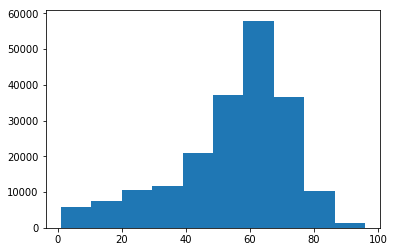

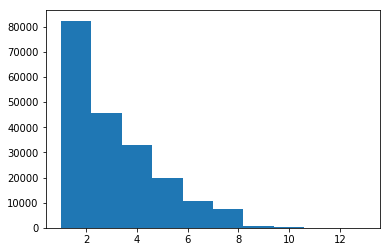

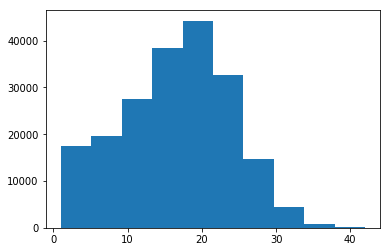

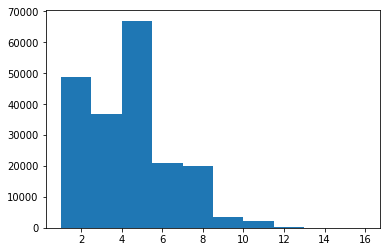

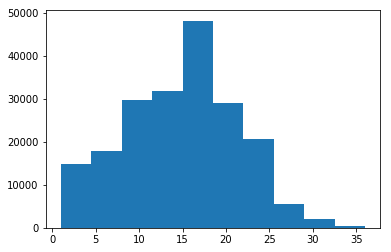

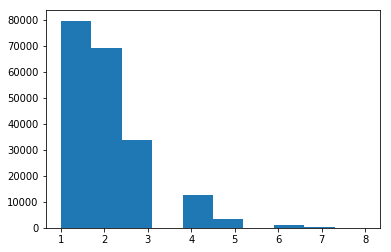

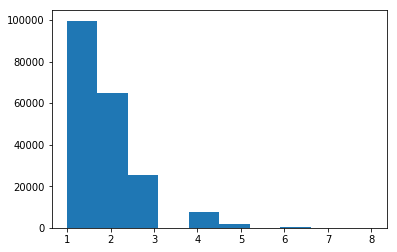

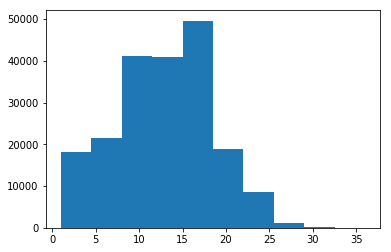

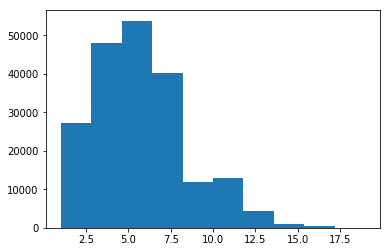

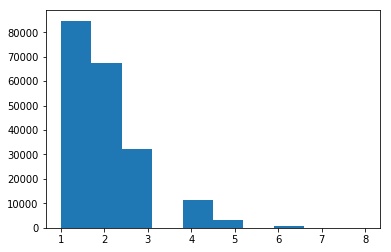

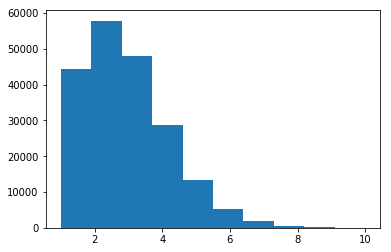

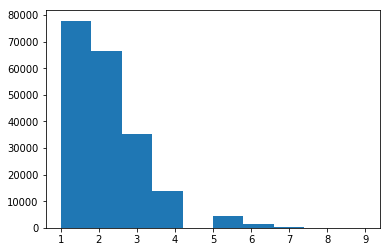

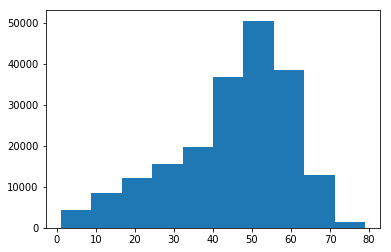

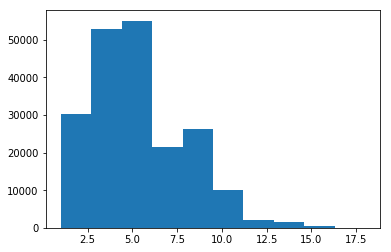

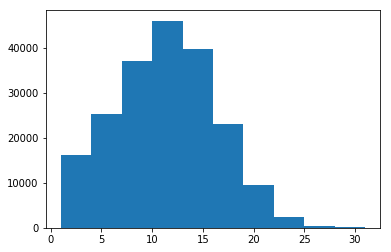

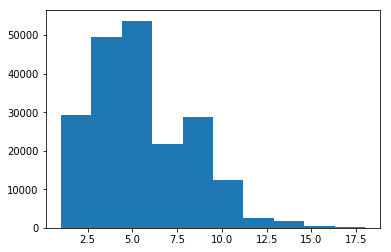

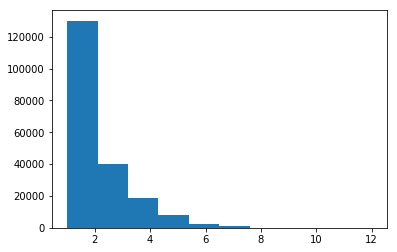

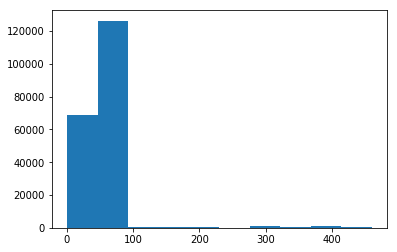

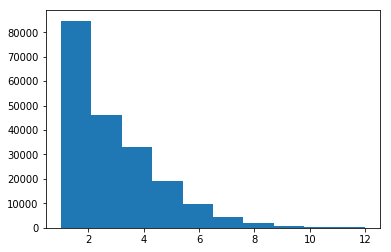

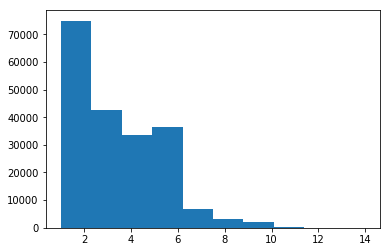

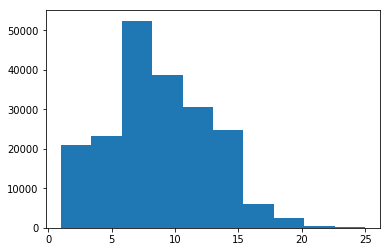

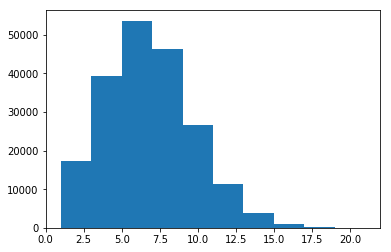

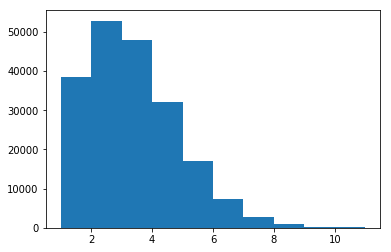

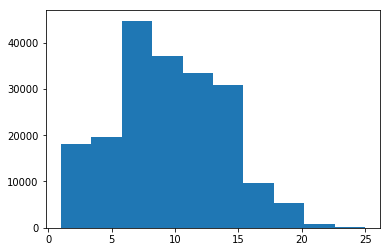

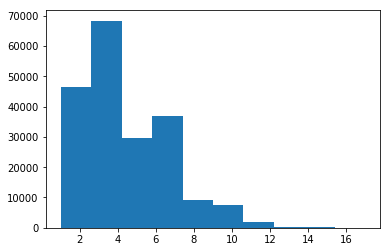

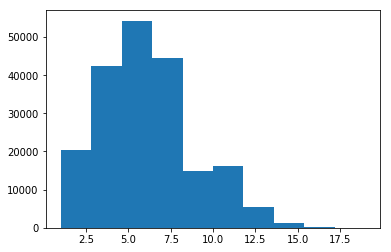

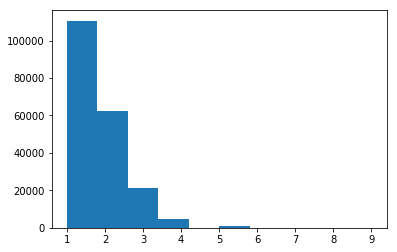

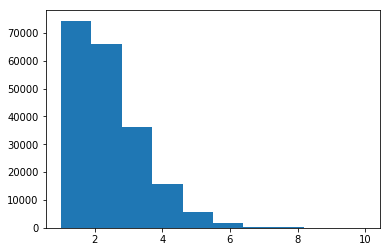

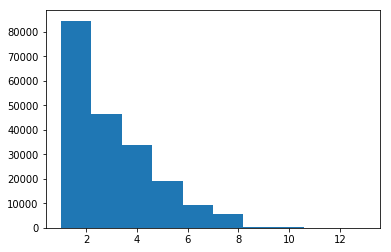

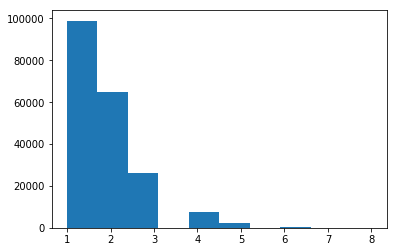

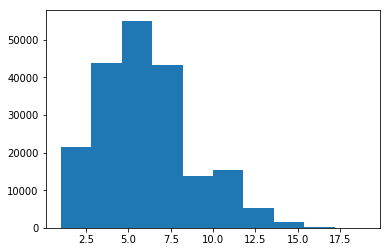

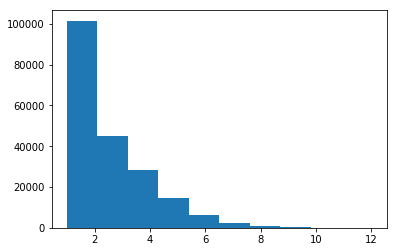

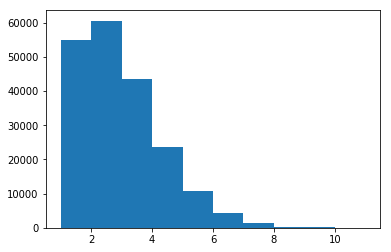

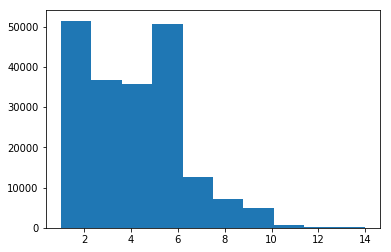

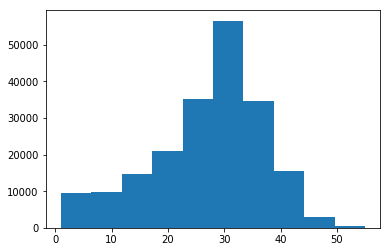

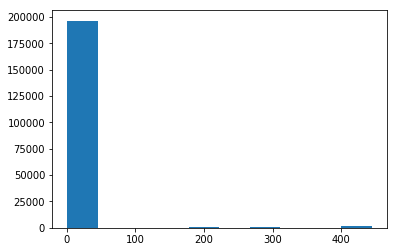

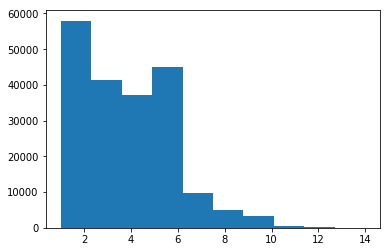

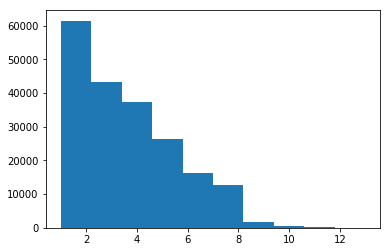

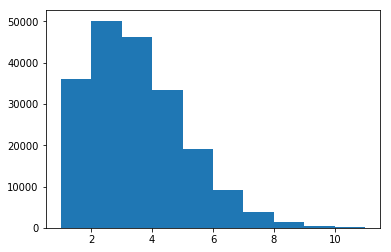

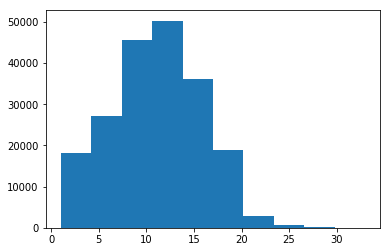

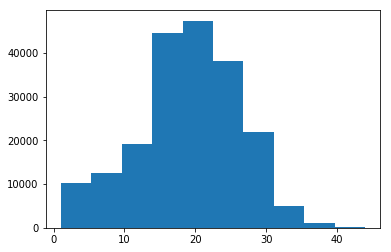

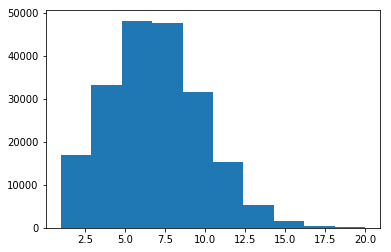

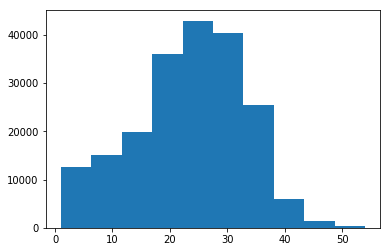

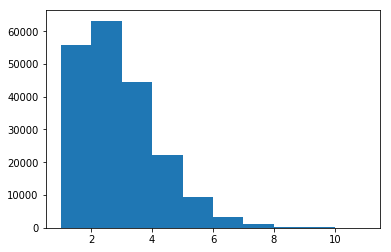

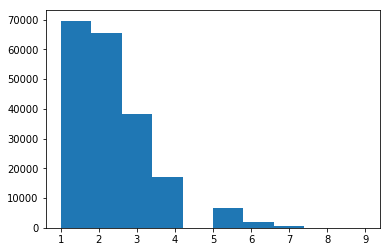

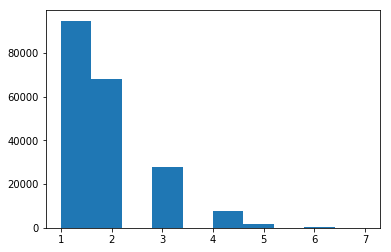

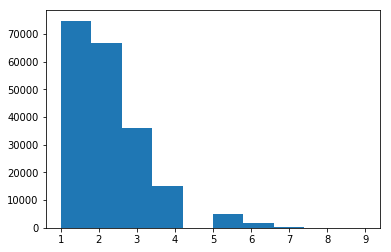

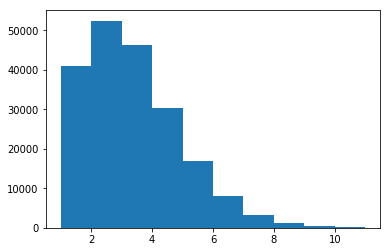

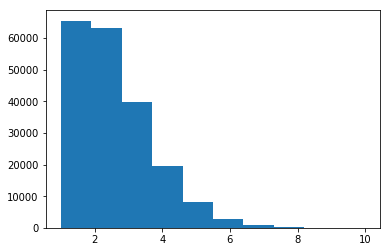

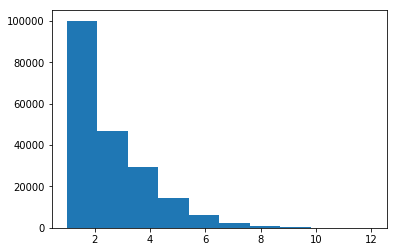

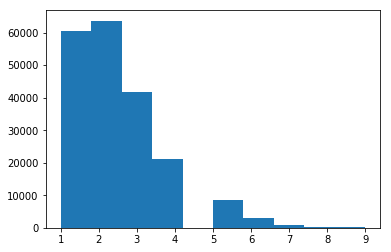

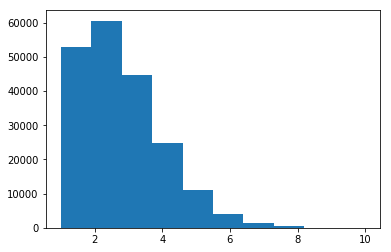

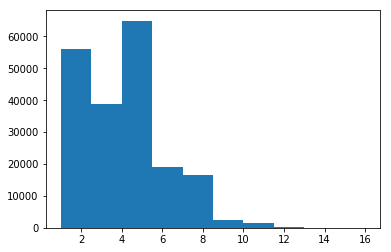

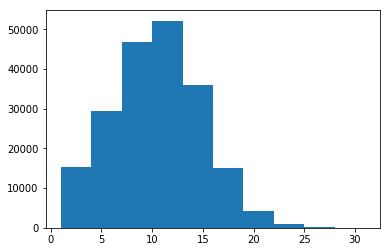

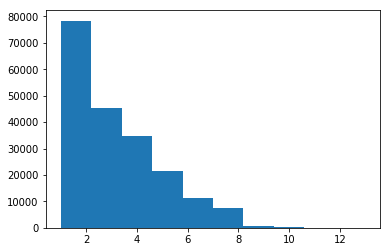

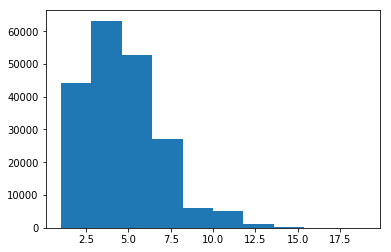

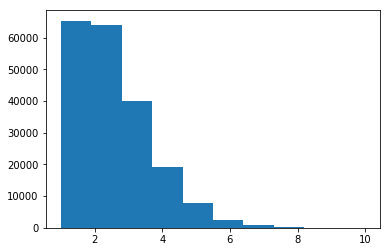

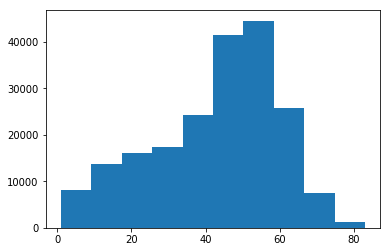

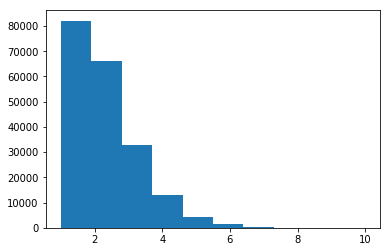

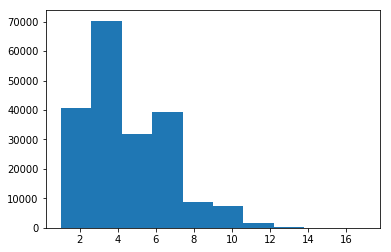

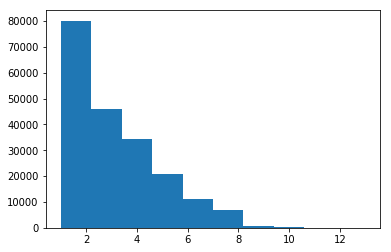

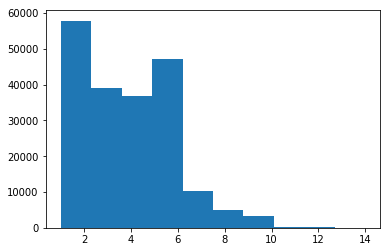

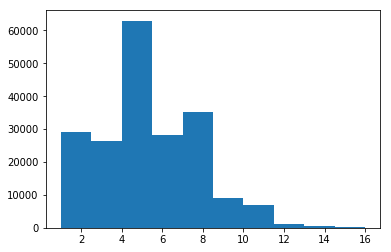

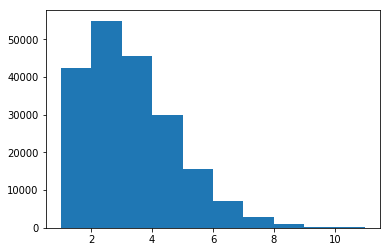

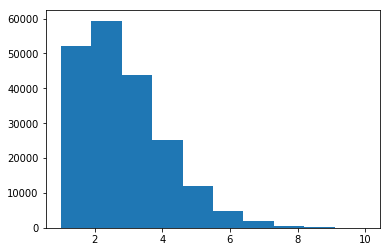

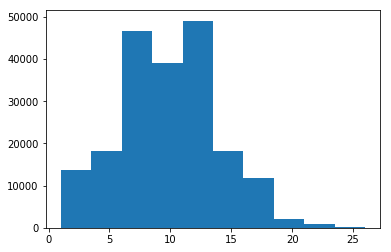

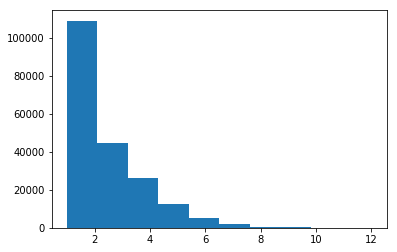

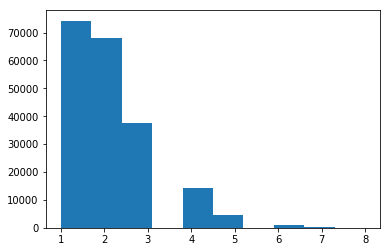

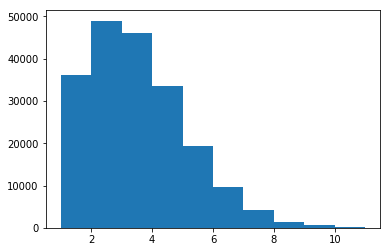

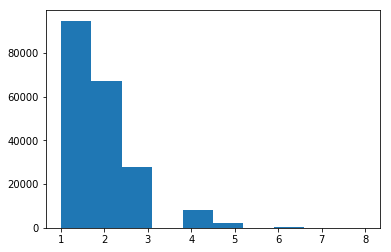

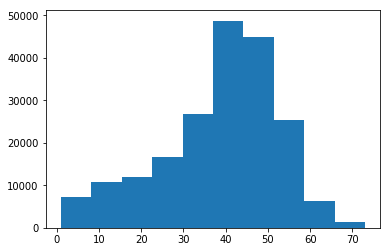

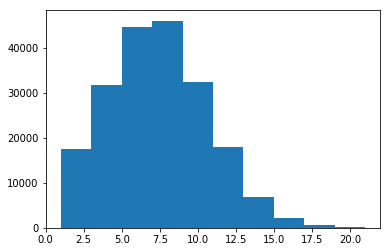

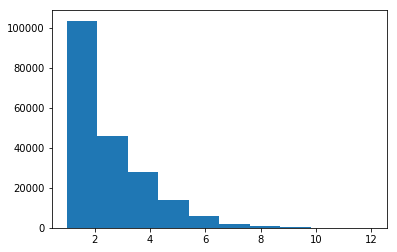

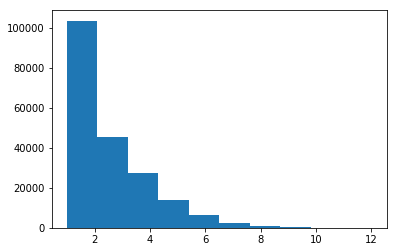

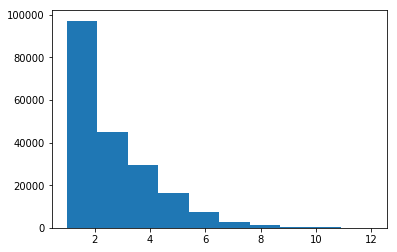

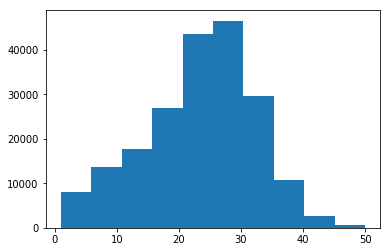

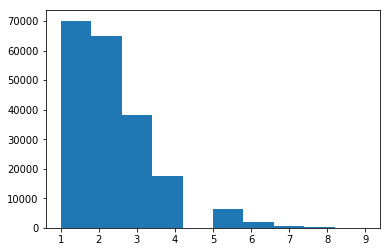

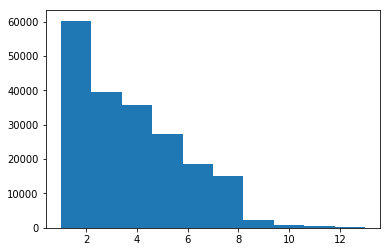

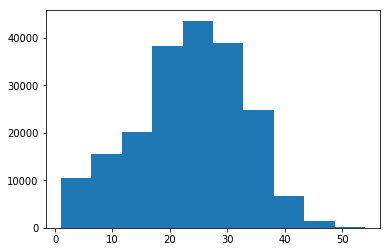

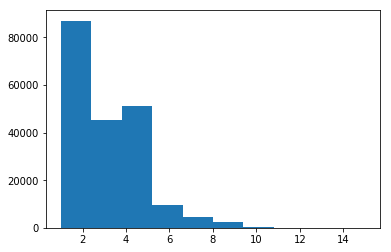

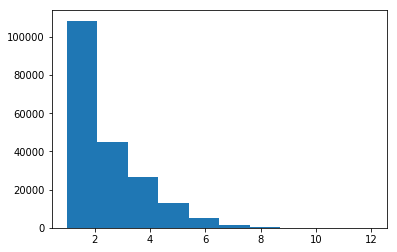

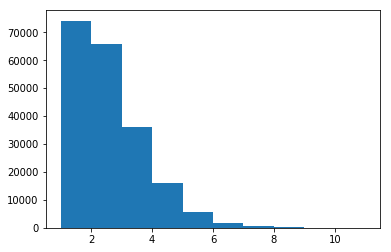

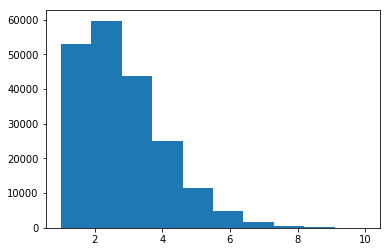

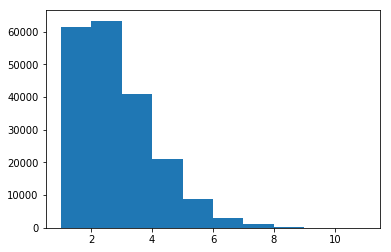

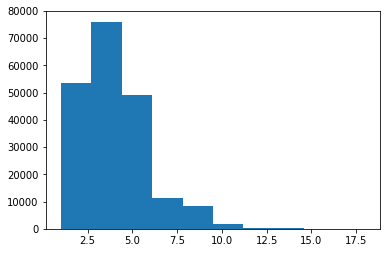

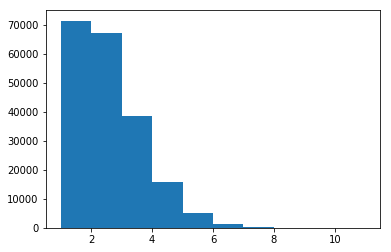

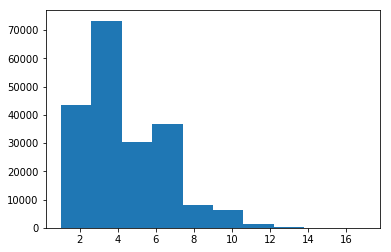

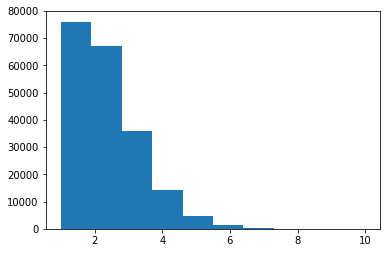

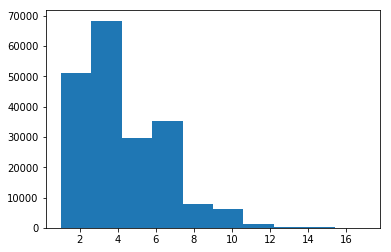

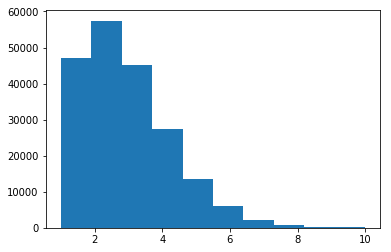

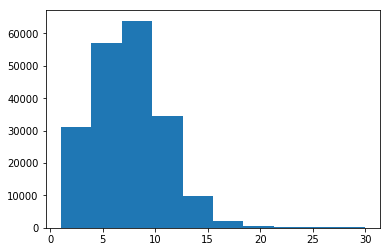

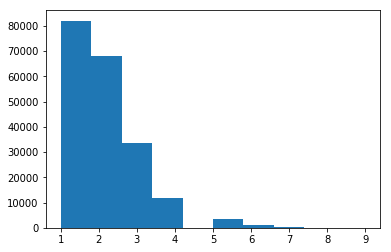

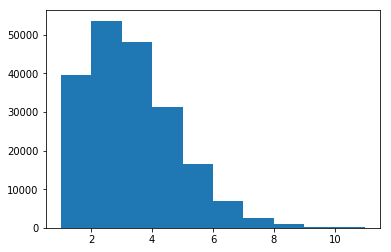

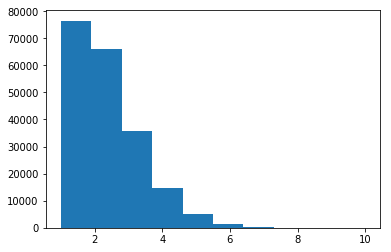

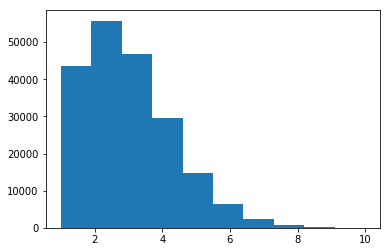

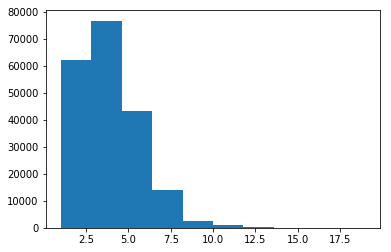

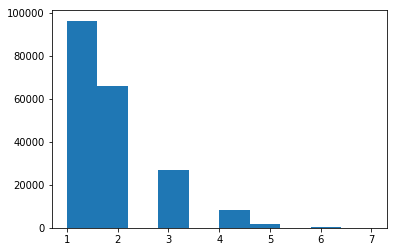

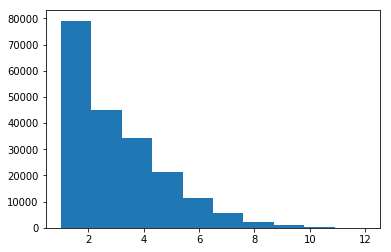

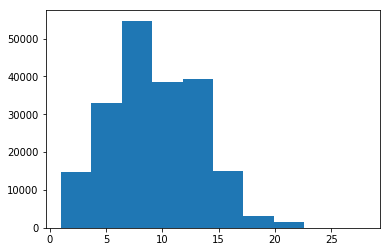

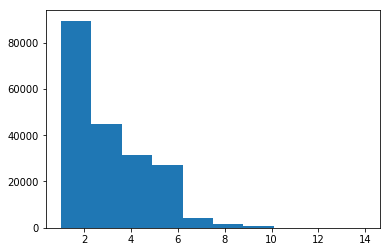

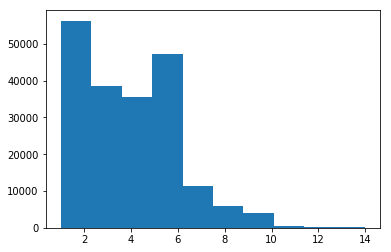

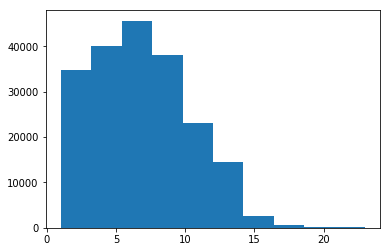

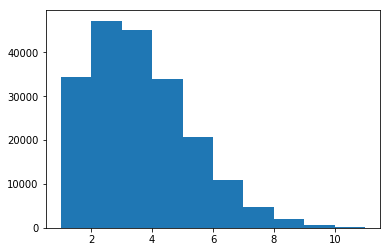

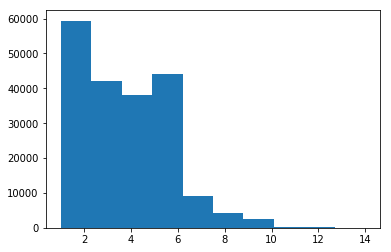

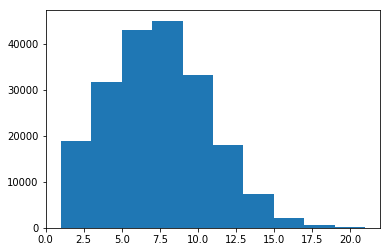

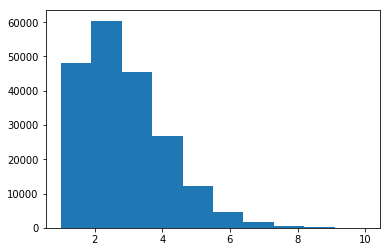

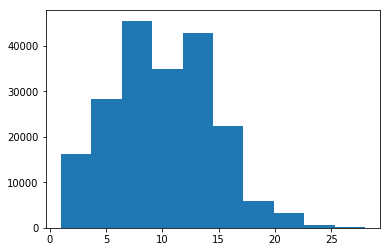

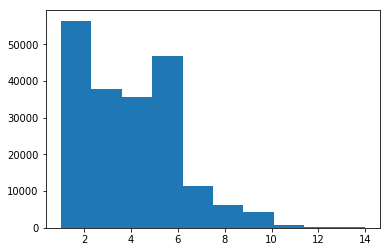

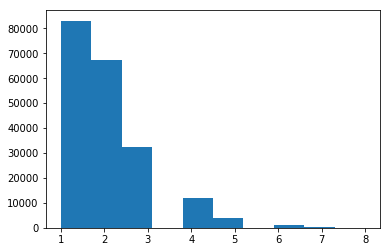

In [6]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

for f in freq_cols:
    plt.hist(train_df[f]); plt.show()

In [7]:
from scipy.special import factorial
all_real = pd.concat([train_df[freq_cols], test_df.loc[real_samples_indexes, freq_cols]], axis=0).reset_index(drop=True)

In [8]:
for f in tqdm(freq_cols):
    vc = all_real[f].value_counts()
    ld = (np.array(vc.index)*vc.values).sum()/vc.sum()
    
    train_df[f+'_poi'] = np.exp(-ld)*(ld**train_df[f])/np.array(factorial(train_df[f])) #(lamb**k/factorial(k)) * np.exp(-lamb)
    test_df[f+'_poi'] = np.exp(-ld)*(ld**test_df[f])/np.array(factorial(test_df[f]))

100%|████████████████████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 15.07it/s]


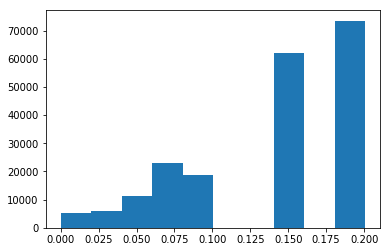

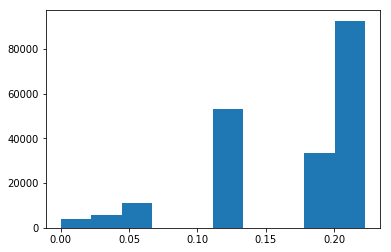

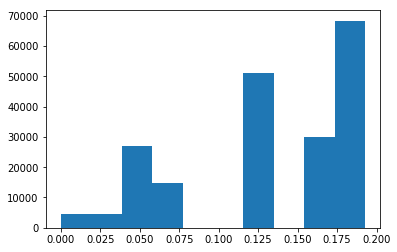

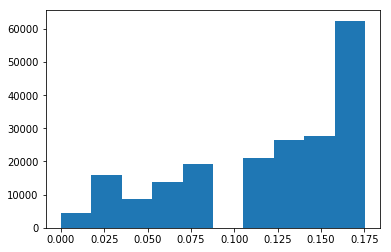

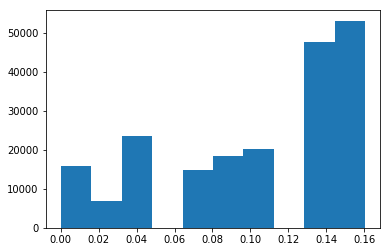

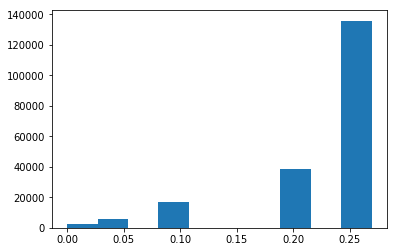

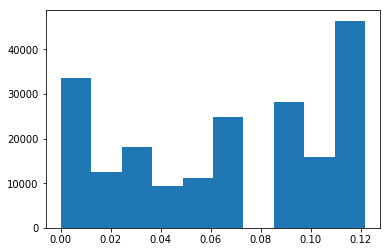

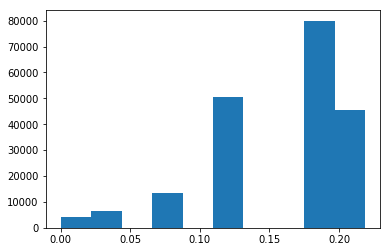

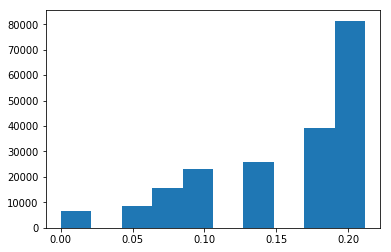

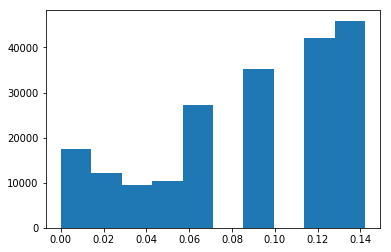

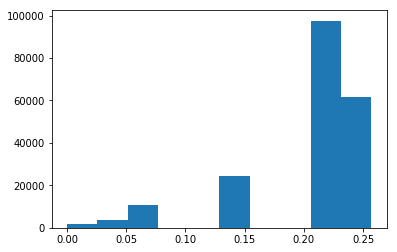

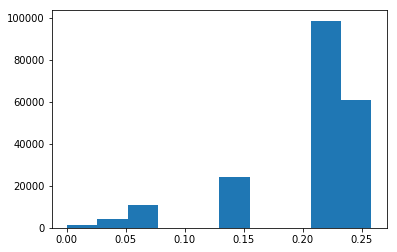

c:\users\khyeh\anaconda3\envs\tensorflow\lib\site-packages\numpy\lib\histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\khyeh\anaconda3\envs\tensorflow\lib\site-packages\numpy\lib\histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


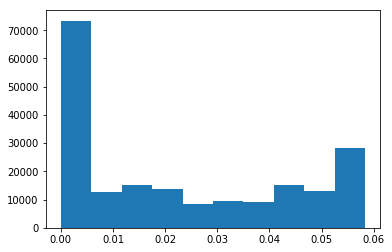

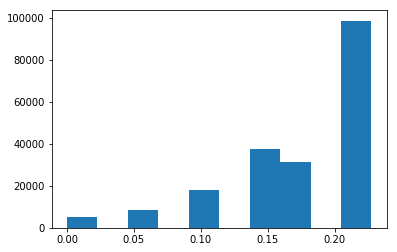

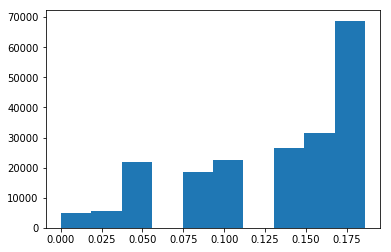

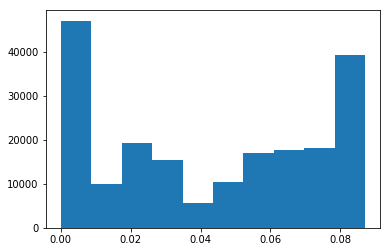

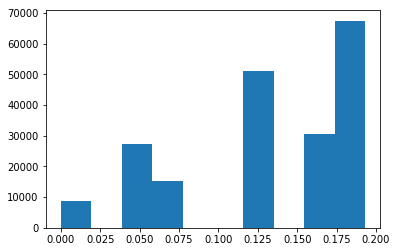

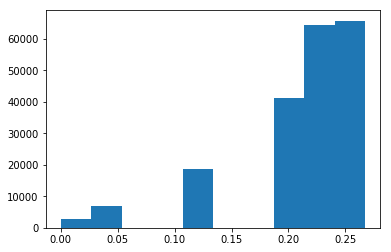

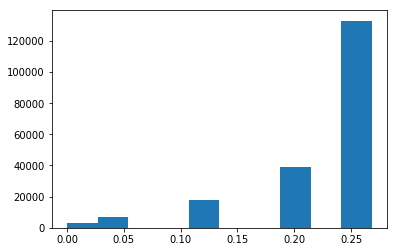

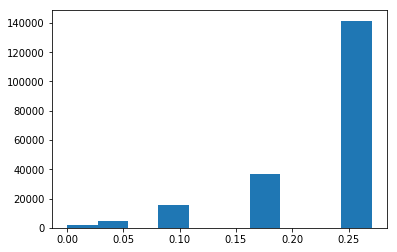

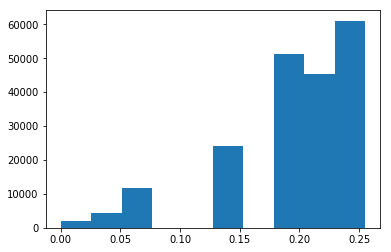

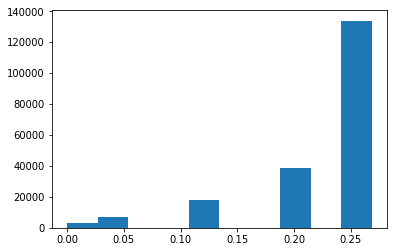

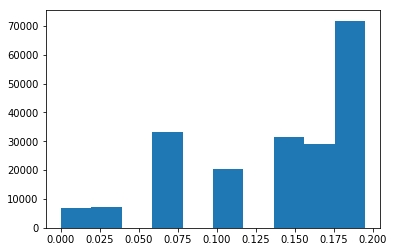

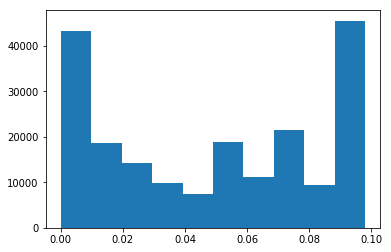

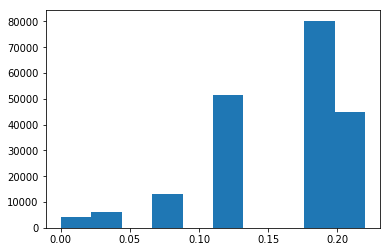

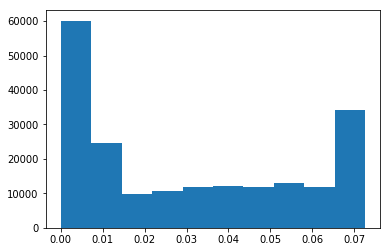

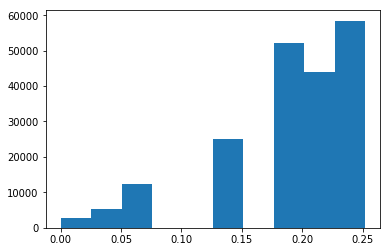

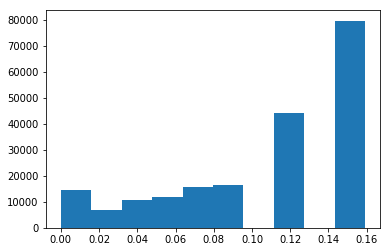

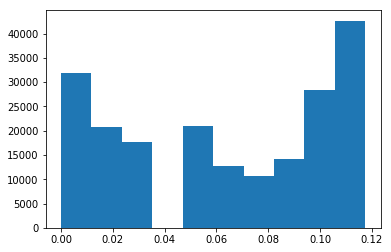

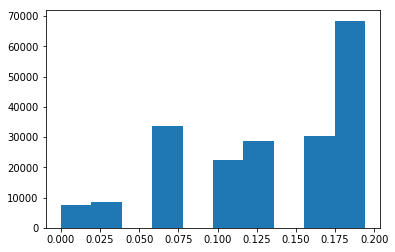

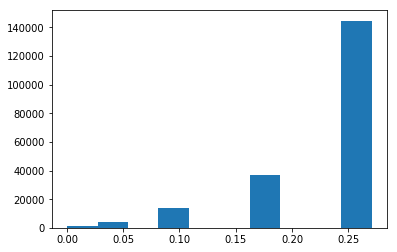

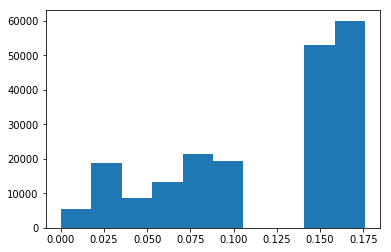

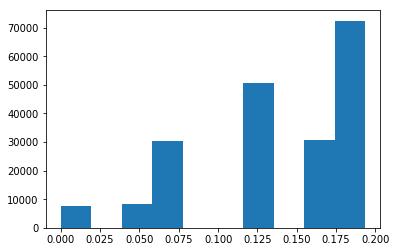

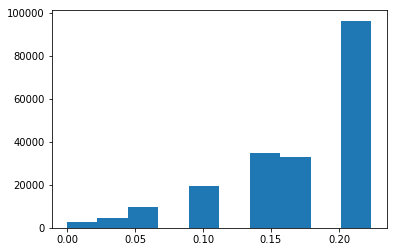

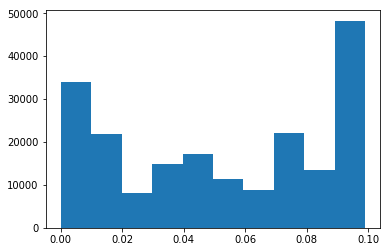

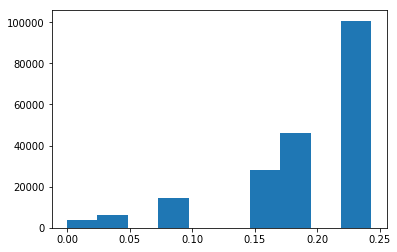

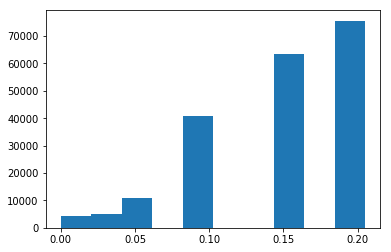

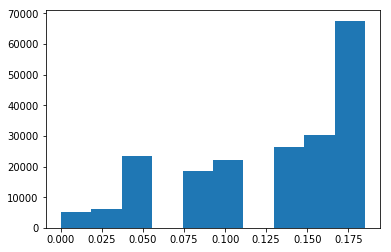

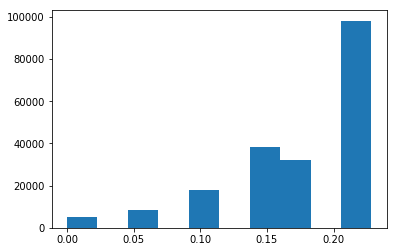

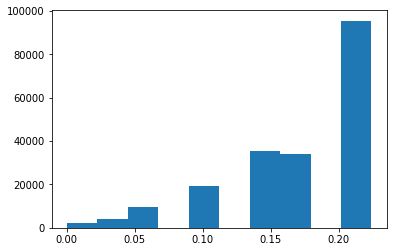

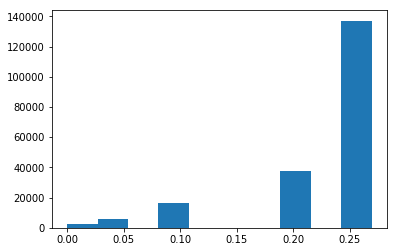

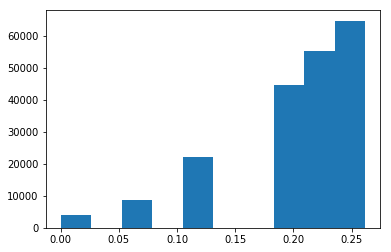

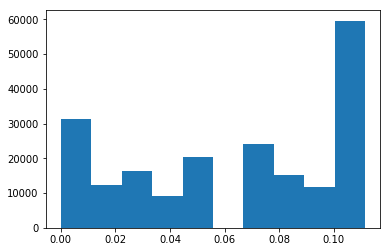

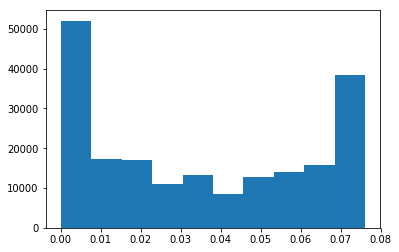

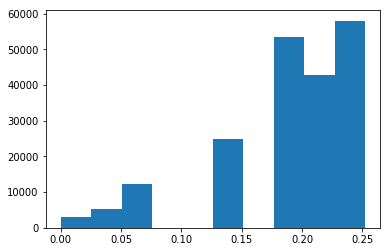

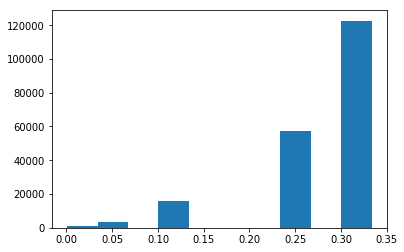

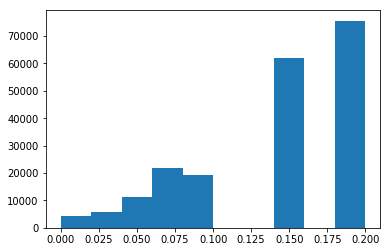

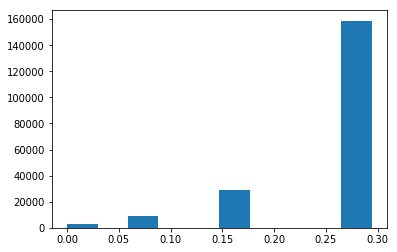

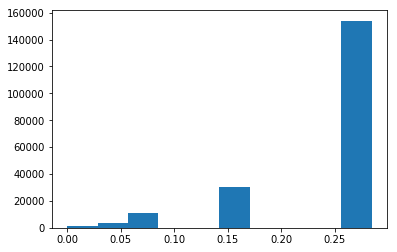

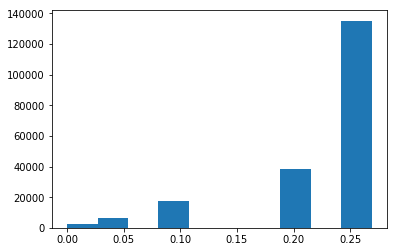

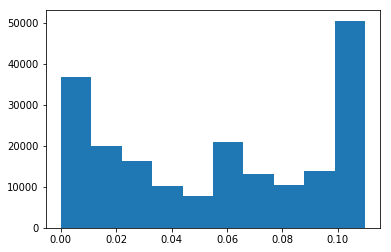

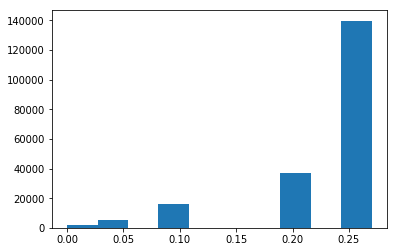

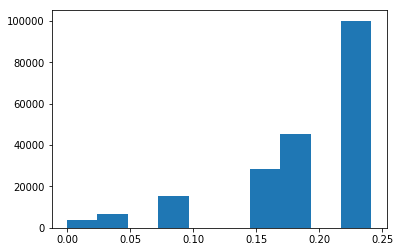

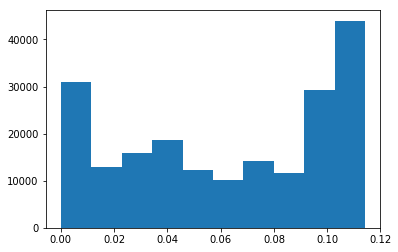

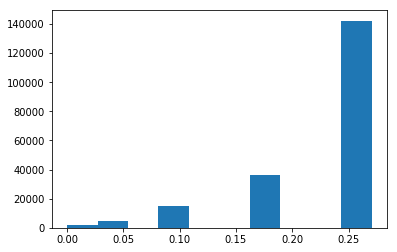

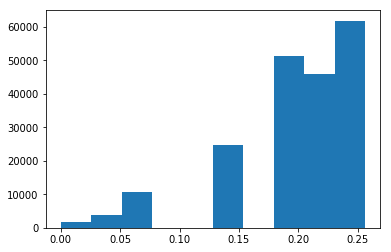

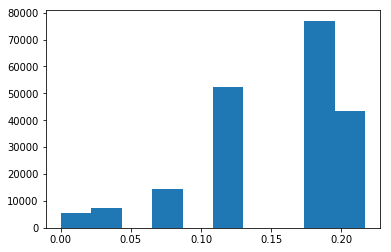

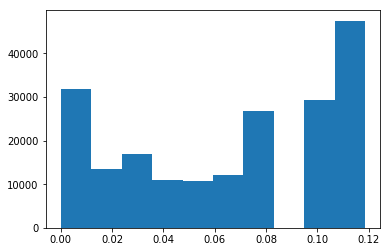

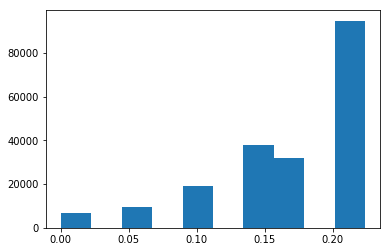

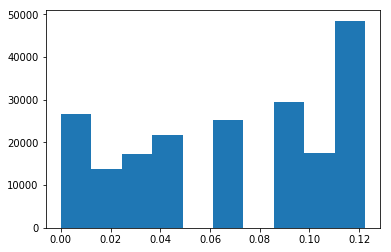

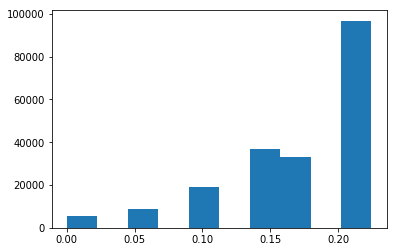

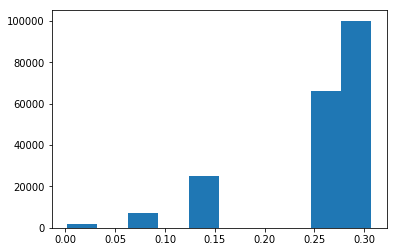

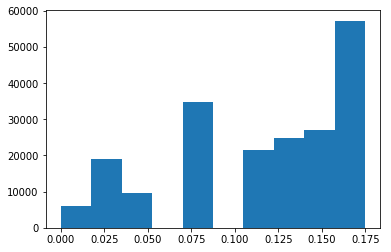

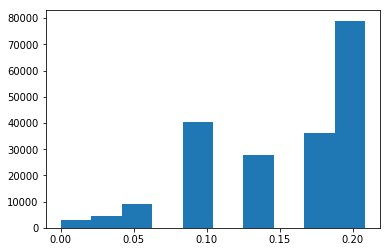

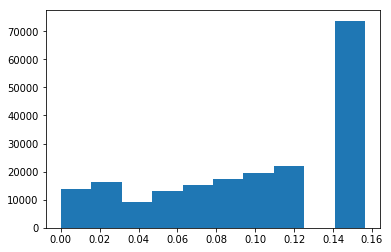

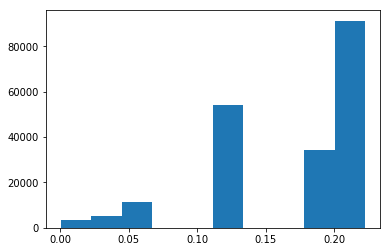

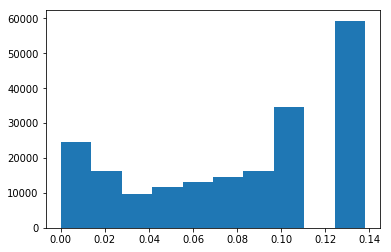

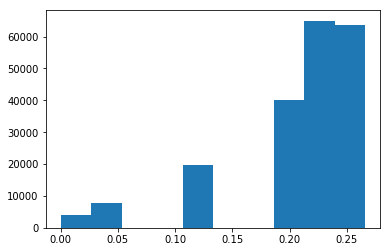

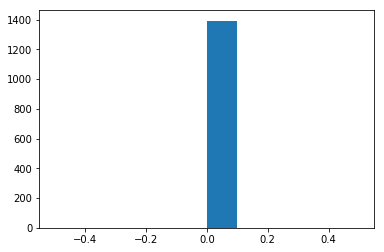

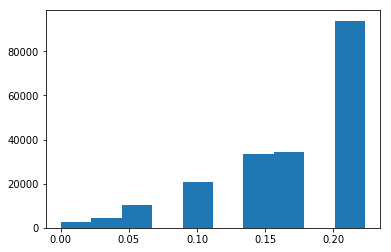

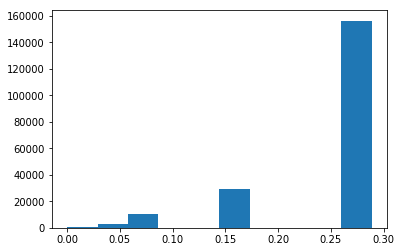

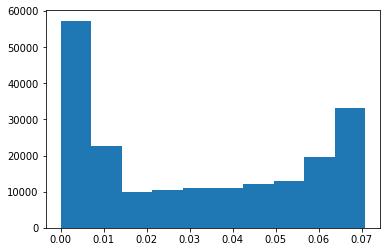

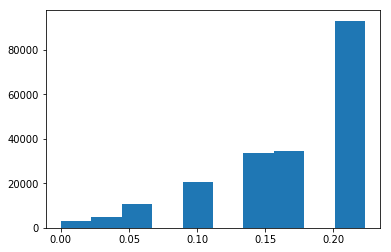

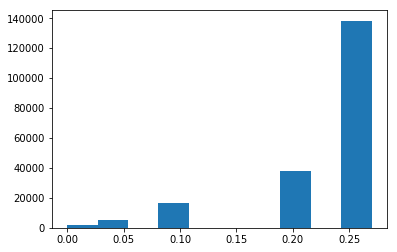

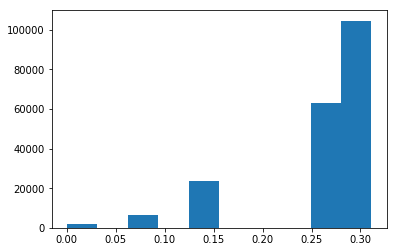

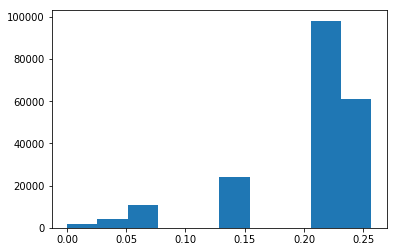

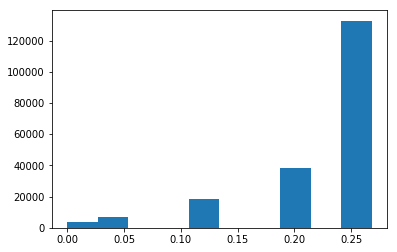

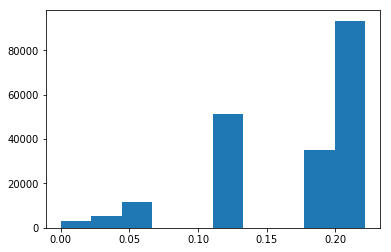

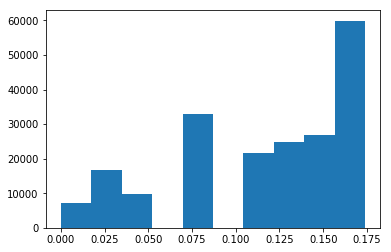

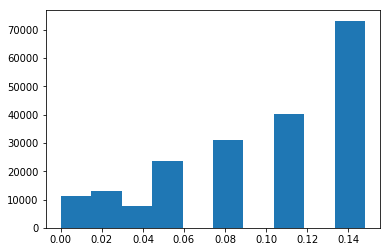

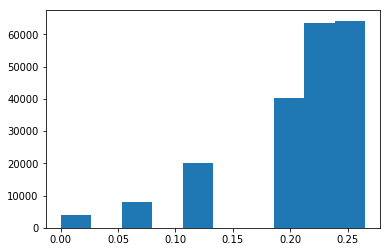

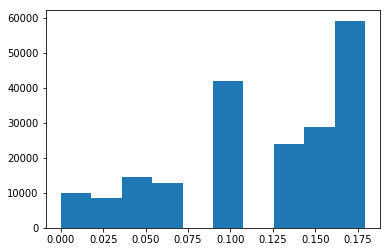

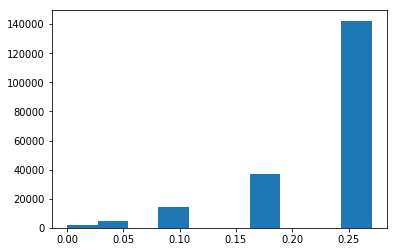

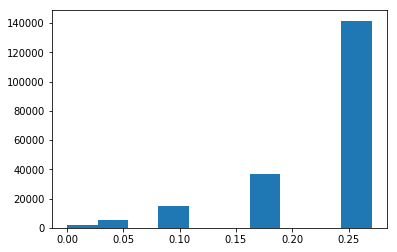

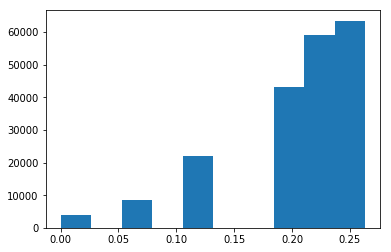

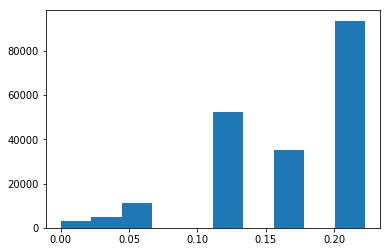

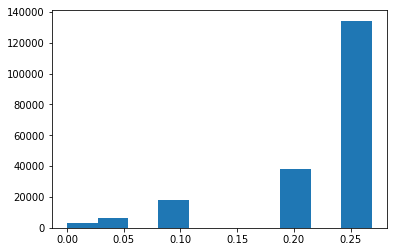

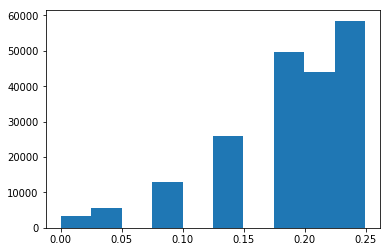

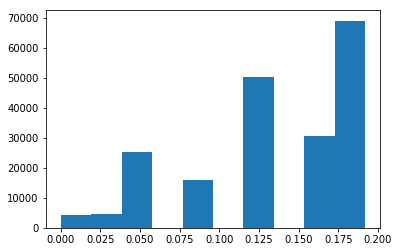

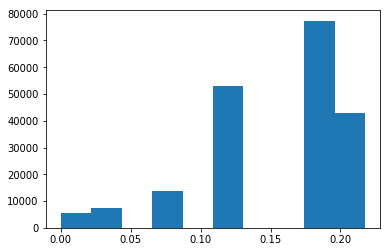

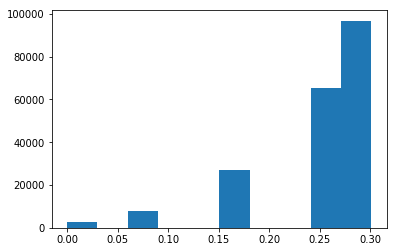

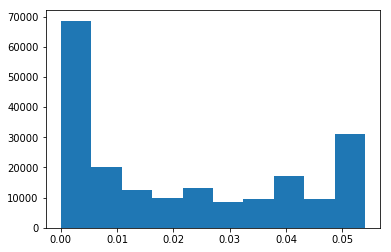

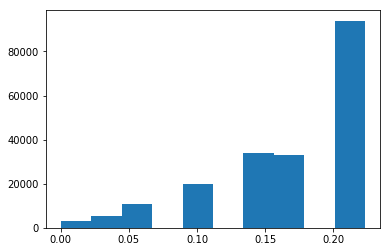

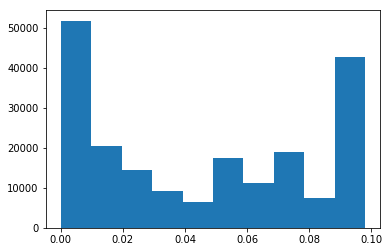

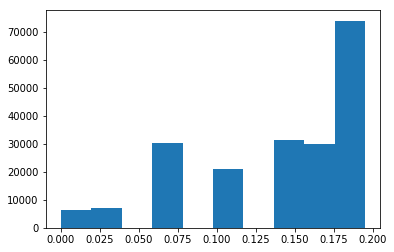

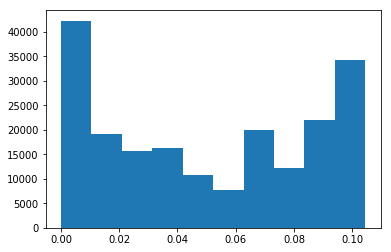

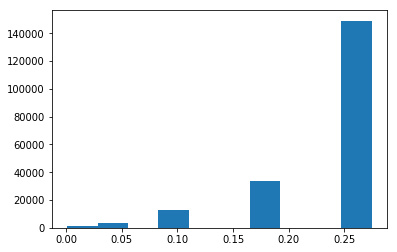

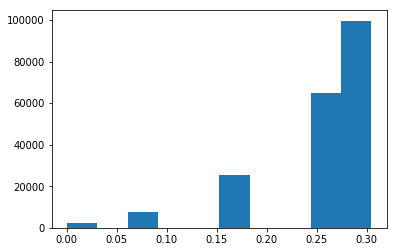

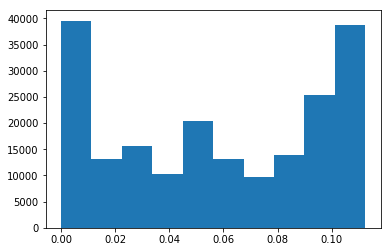

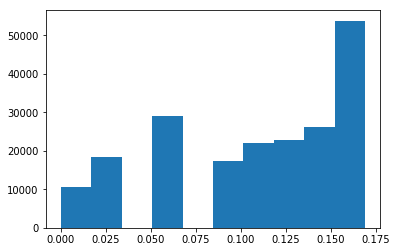

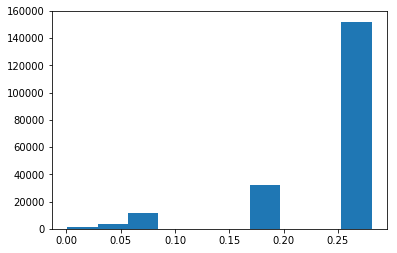

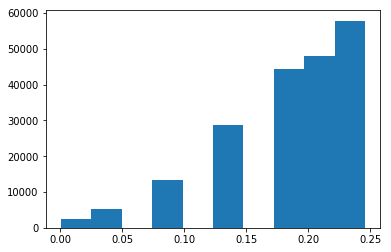

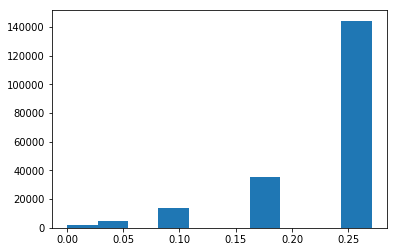

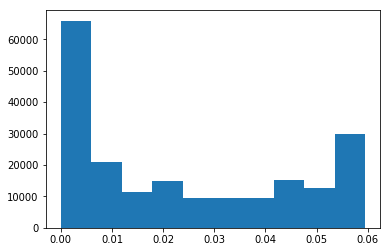

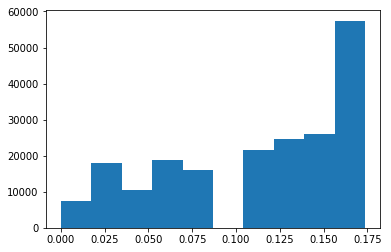

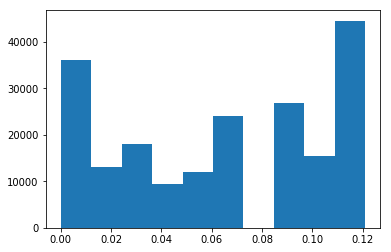

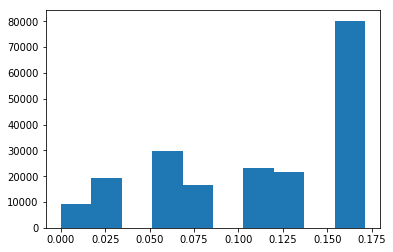

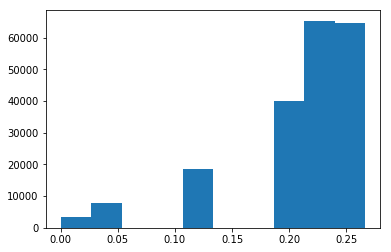

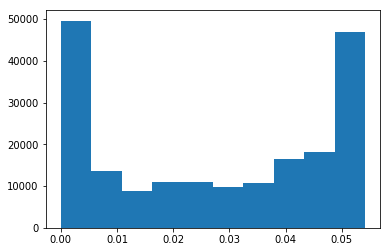

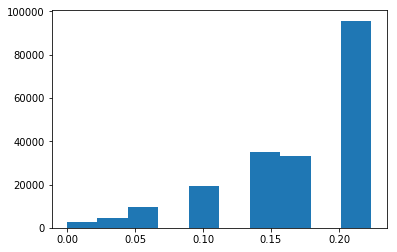

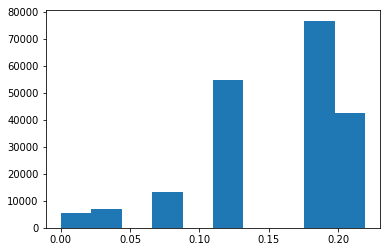

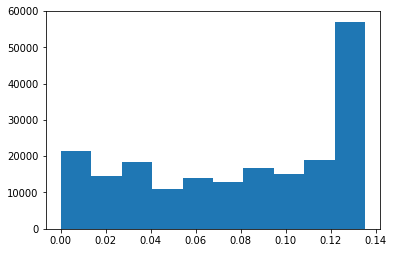

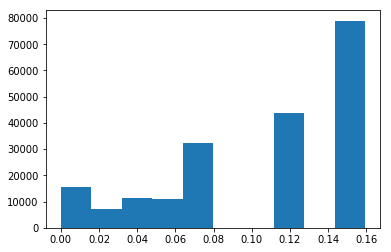

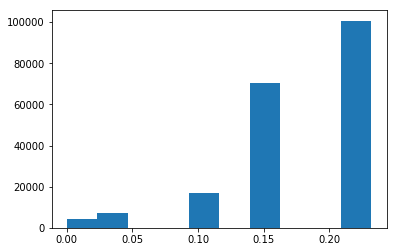

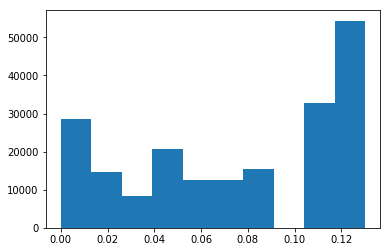

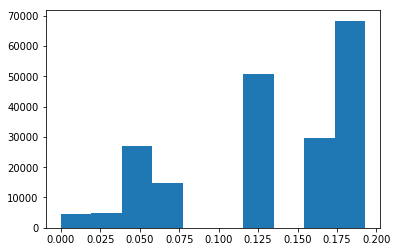

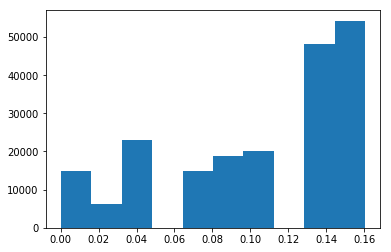

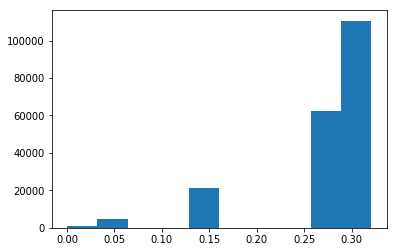

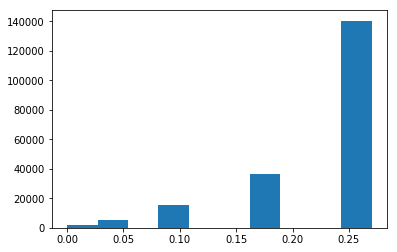

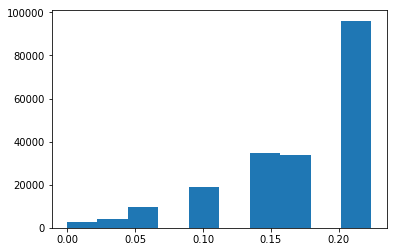

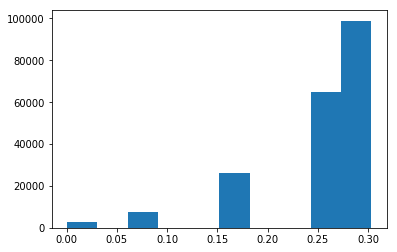

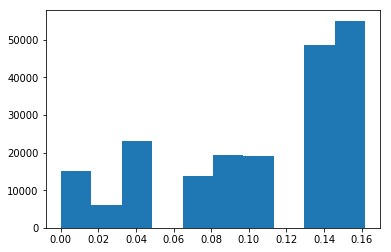

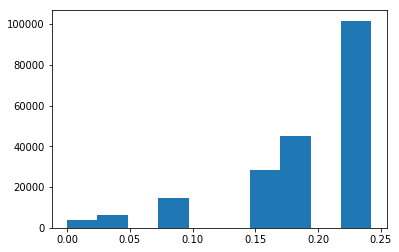

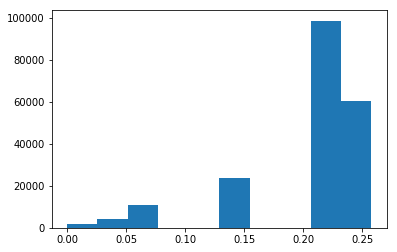

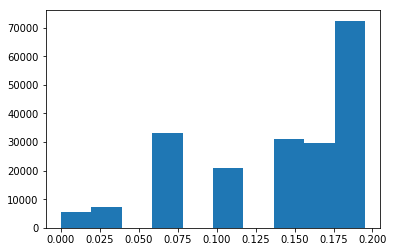

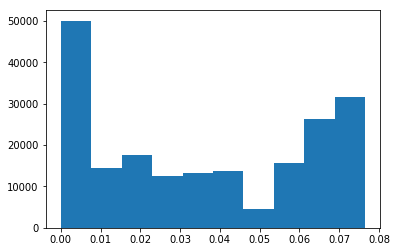

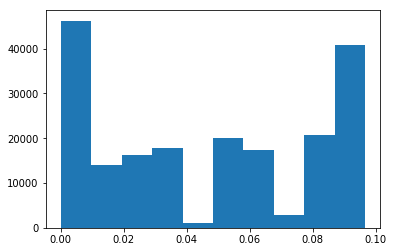

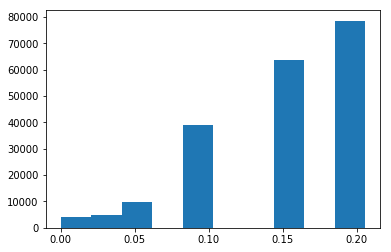

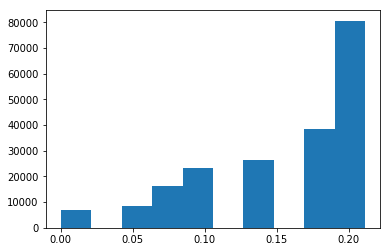

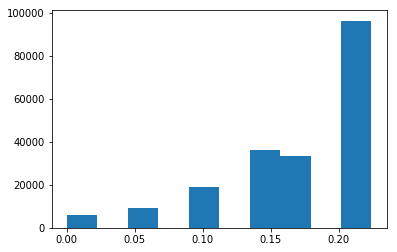

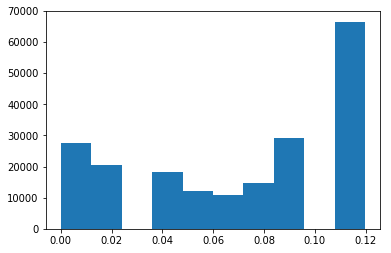

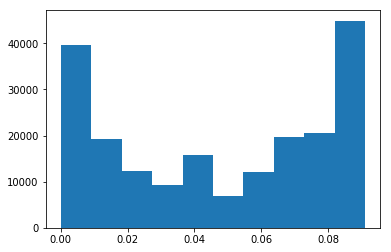

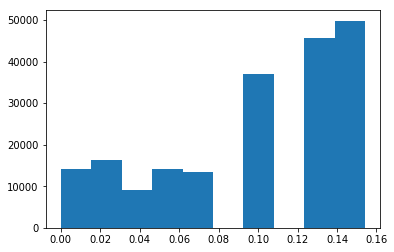

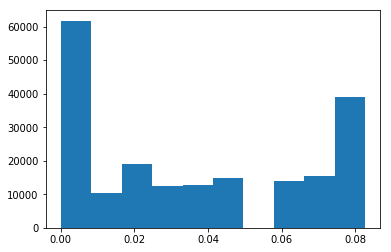

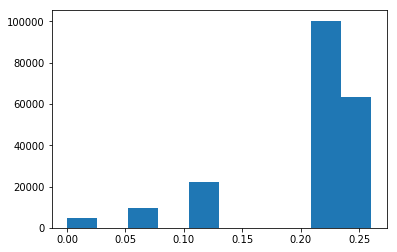

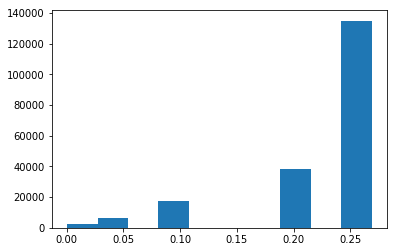

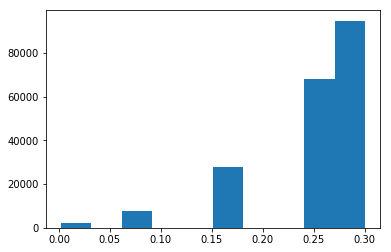

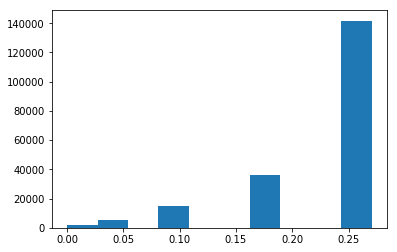

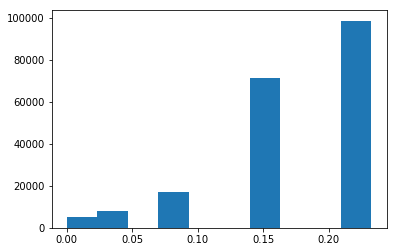

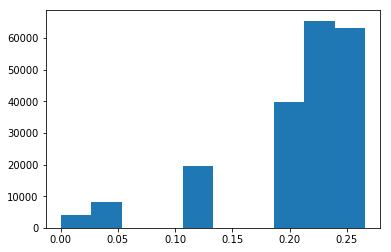

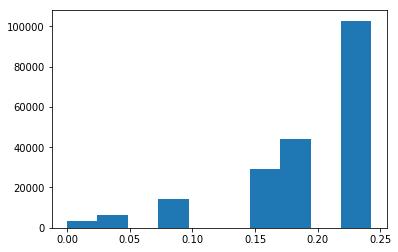

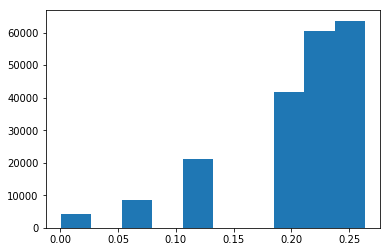

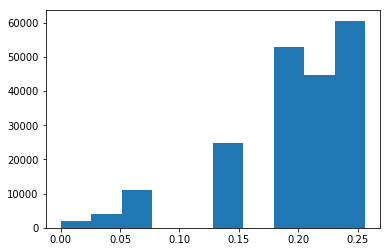

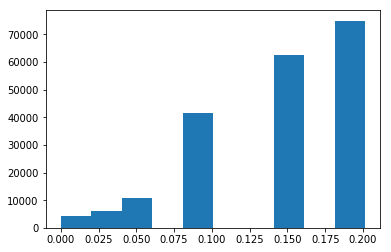

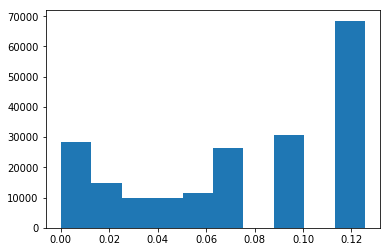

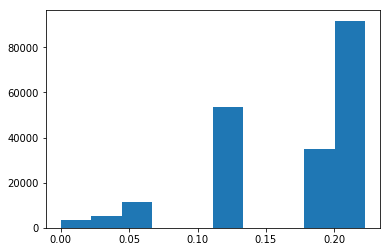

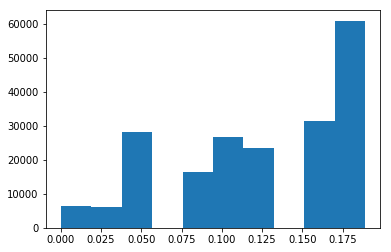

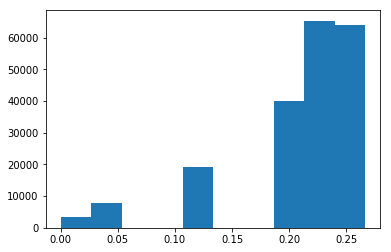

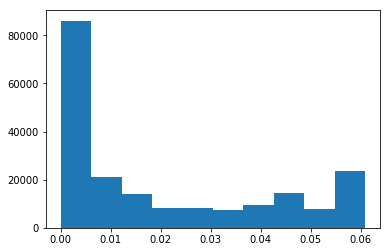

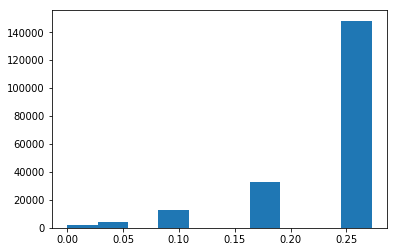

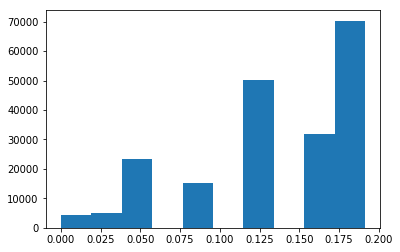

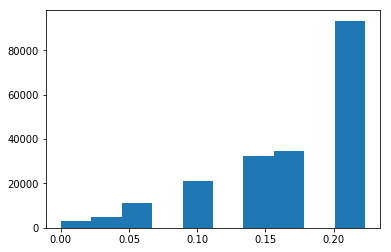

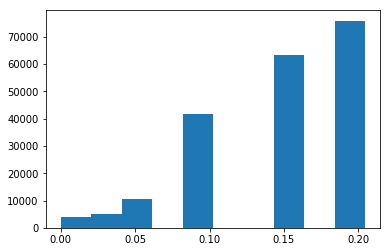

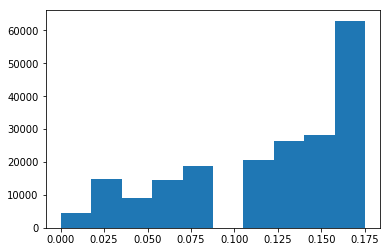

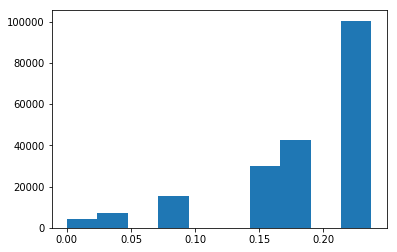

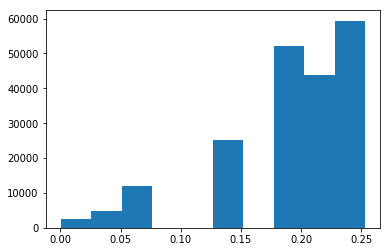

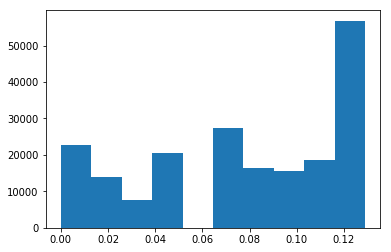

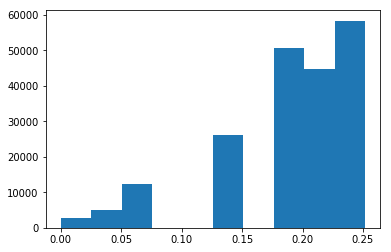

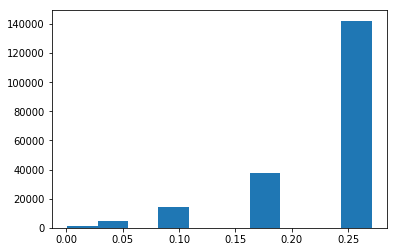

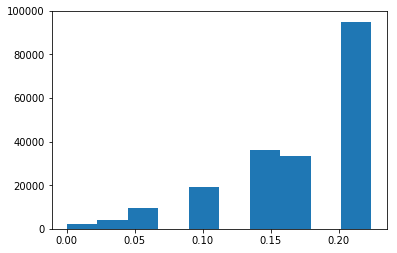

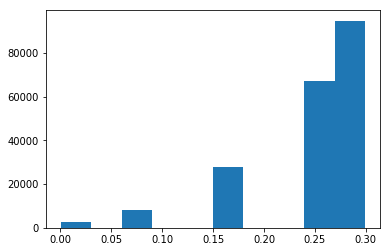

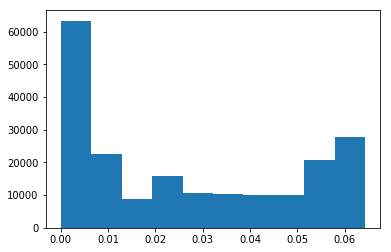

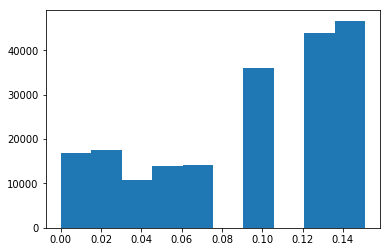

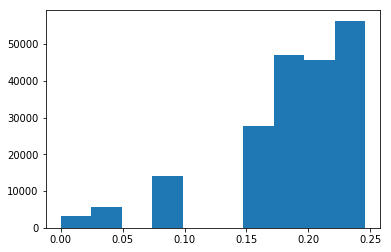

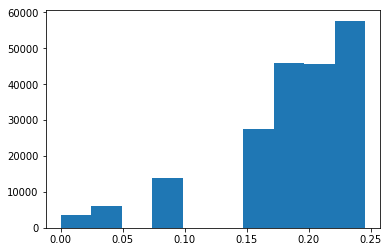

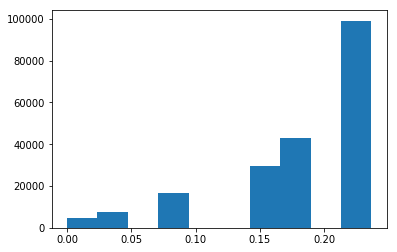

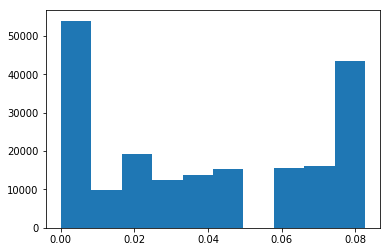

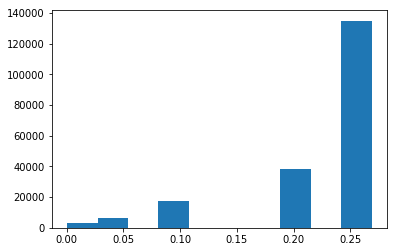

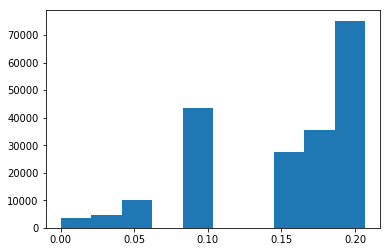

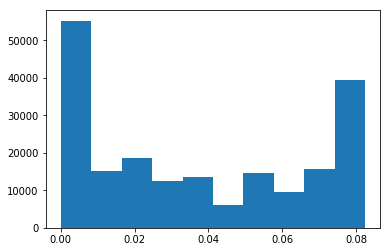

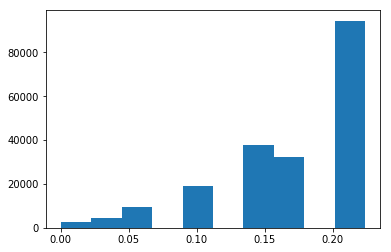

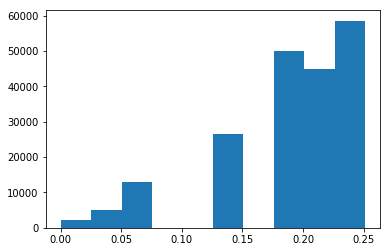

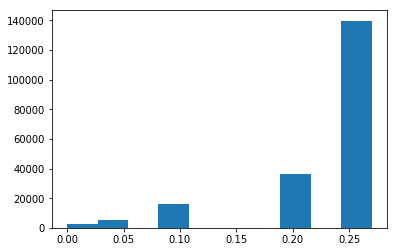

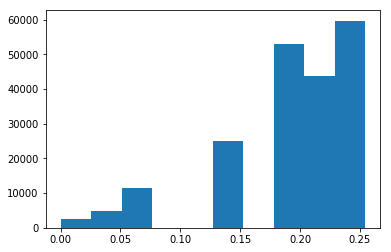

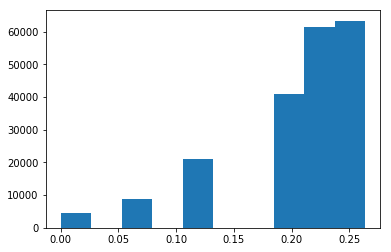

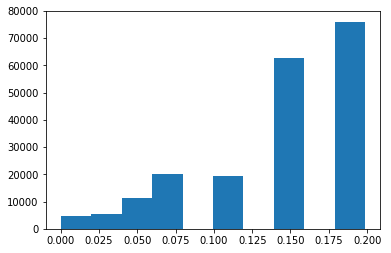

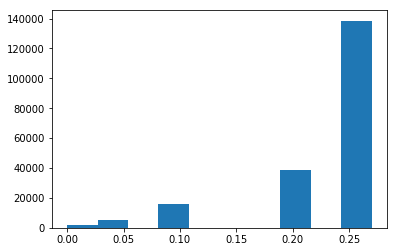

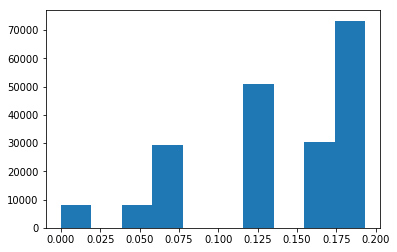

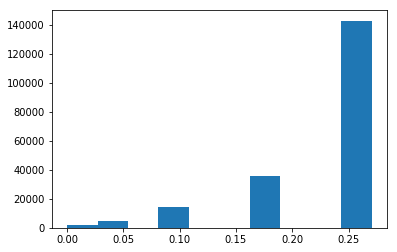

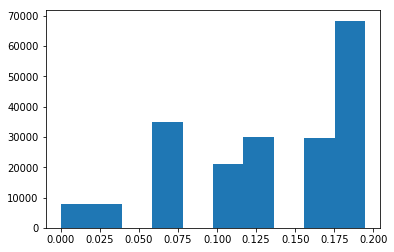

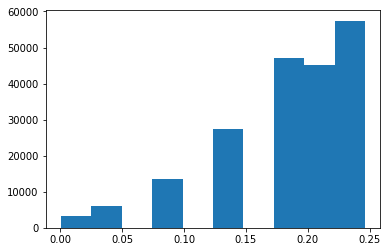

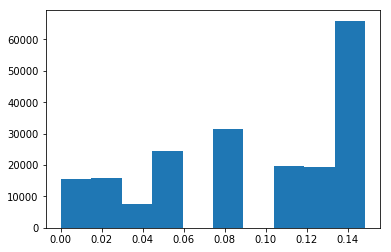

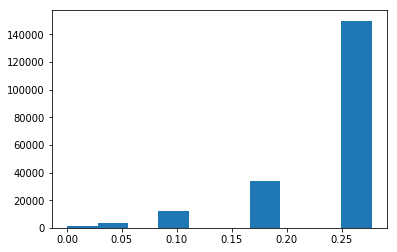

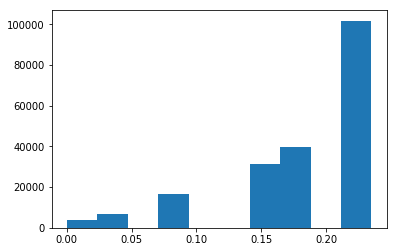

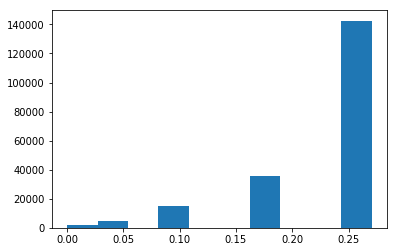

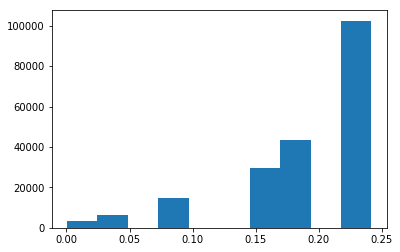

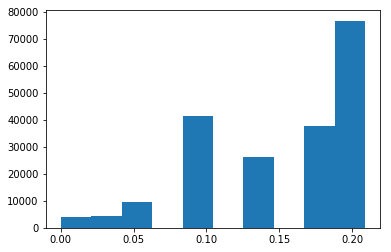

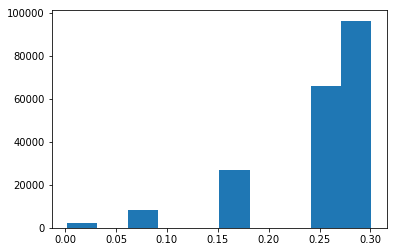

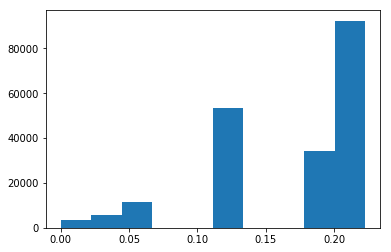

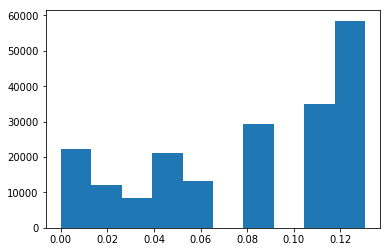

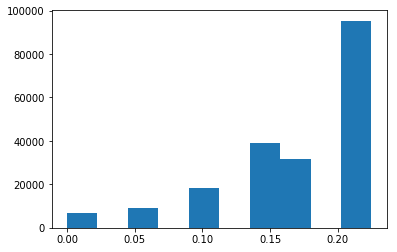

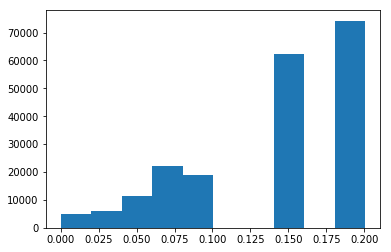

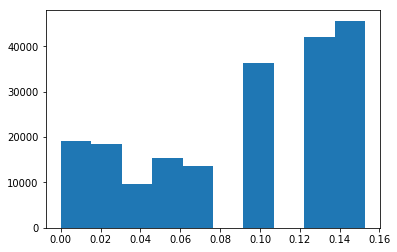

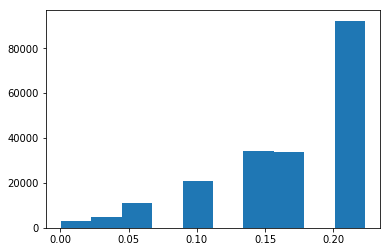

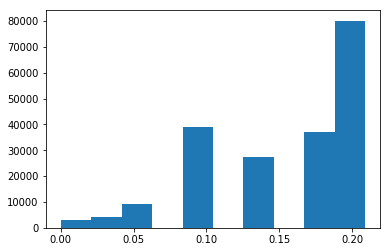

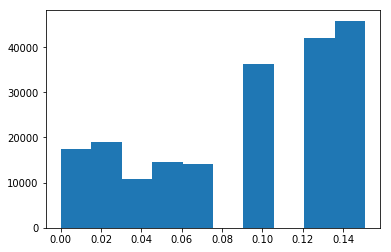

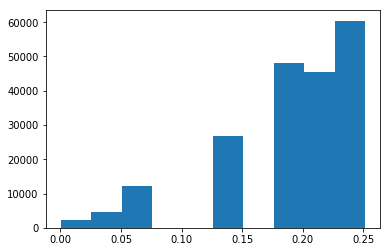

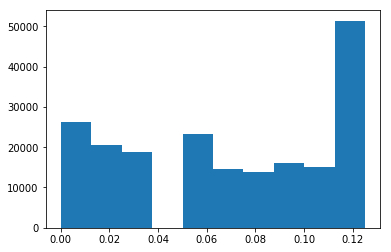

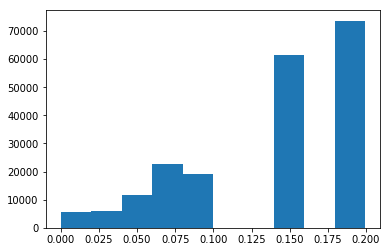

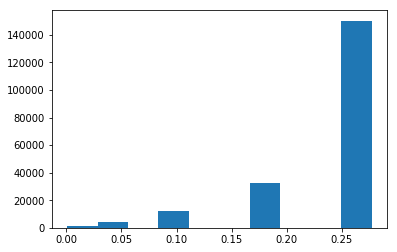

In [9]:
for f in freq_cols:
    plt.hist(train_df[f+'_poi']); plt.show()

In [10]:
poi_cols = [f+'_poi' for f in freq_cols]
train_df[poi_cols].to_pickle('features/poisson_prob_train.pkl')
test_df[poi_cols].to_pickle('features/poisson_prob_test.pkl')